In [1]:
import os
import re
import sys

import itertools
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import spearmanr
from statsmodels.stats import multitest

import pytorch_lightning as pl
import scanpy as sc
from anndata import AnnData

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import textwrap
import torch
import torch.nn as nn

import gseapy as gp

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import calculate_DxC_gene_effect, select_important_genes_for_factor_IQR, calculate_DxC_effect, assign_D_to_celltype
from src.analysis.plotting import make_gp_dotplot, plot_gene_loadings_for_factor, plot_gene_loadings_for_associated_variable

Seed set to 32
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")

if "age_scaled" not in adata.obs.columns:
    age_scaled = StandardScaler().fit_transform(adata.obs.age.to_numpy().reshape(-1,1))
    age_scaled = pd.DataFrame(age_scaled, index=adata.obs.index, columns=["age_scaled"])
    adata.obs = adata.obs.merge(age_scaled, left_index=True, right_index=True)

adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1', 'age_scaled'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downre

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)

adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)

In [266]:
adata.var.to_csv("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K_adata-var.tsv", sep="\t", header=True, index=True)

In [4]:
# COLORS FROM THE ORIGINAL PUBLICATION
cell_label_colors = {
    "CD4 SOX4": "#D6C1DE", # SOX4+ CD4 T cells
    "CD4 NC": "#882E72", # CD4 naive T cells
    "CD4 ET": "#B178A6", # CD4 effectorT  cells
    "CD8 NC": "#5289C7", # CD8 naive T cells
    "CD8 S100B": "#7BAFDE", # S100B+ CD8 cells
    "CD8 ET": "#1965B0", # CD8 effector cells 
    "NK": "#4EB265",
    "NK R": "#90C987", # NK recruiting cells
    "B IN": "#F6C141",
    "B Mem": "#F7EE55",
    "Mono C": "#F1932D", # classical monocytes
    "Mono NC": "#E8601C", # non-classical monocytes
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

In [5]:
adata.uns["cell_label_colors"] = [cell_label_colors[ct] for ct in adata.obs.cell_label.cat.categories]

In [7]:
background_genes = adata.var.GeneSymbol

# databases_bio = ["GO_Biological_Process_2023", "Elsevier_Pathway_Collection",  "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 
databases_bio = ["GO_Biological_Process_2023", "GO_Molecular_Function_2023", "KEGG_2021_Human", "Reactome_2022"] 


databases_disease = ["DisGeNET", "Disease_Signatures_from_GEO_up_2014", "Disease_Signatures_from_GEO_down_2014", "RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO",
                     "Human_Phenotype_Ontology", "UK_Biobank_GWAS_v1"]

databases_disease_min = ["DisGeNET", "Disease_Signatures_from_GEO_up_2014", "Disease_Signatures_from_GEO_down_2014", "Human_Phenotype_Ontology", "UK_Biobank_GWAS_v1"]


In [8]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

In [9]:
sc.settings.figdir = os.path.join(model_results_dir, "Figures")

In [121]:
cell_state = pd.read_csv(os.path.join(model_results_dir,
                                    f"{model}_cell-state_latent.tsv"),
                               sep="\t", index_col=0)

In [10]:
umap_cc = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_cell-state_latent_UMAP.tsv"),
    sep="\t", index_col=0
)

In [11]:
adata.obsm["X_umap"] = umap_cc.loc[adata.obs.index].to_numpy()

In [13]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix.columns = assignment_matrix.columns.str.replace("U_", "D_")
assignment_matrix.head()

D_Factor1     D_Factor2  D_Factor3     D_Factor4  \
Cell-state_Factor1  8.437773e-07  7.903217e-08   0.000149  2.960464e-08   
Cell-state_Factor2  1.292795e-06  6.067657e-08   0.000136  6.915393e-08   
Cell-state_Factor3  9.953613e-07  6.230532e-08   0.000141  1.447328e-06   
Cell-state_Factor4  6.680752e-07  6.124807e-02   0.000136  3.778137e-08   
Cell-state_Factor5  4.728630e-06  2.615931e-08   0.000146  6.789284e-04   

                    D_Factor5     D_Factor6     D_Factor7  D_Factor8  \
Cell-state_Factor1   0.105288  9.999727e-01  5.675518e-07   0.958925   
Cell-state_Factor2   0.105908  1.794856e-02  5.106163e-07   0.115423   
Cell-state_Factor3   0.000004  4.638549e-07  9.892867e-01   0.965989   
Cell-state_Factor4   0.011434  4.063994e-07  9.991040e-01   0.019197   
Cell-state_Factor5   0.123782  2.302163e-07  5.004259e-07   1.000000   

                    D_Factor9  D_Factor10  ...   D_Factor691   D_Factor692  \
Cell-state_Factor1   0.000287    0.000158  ...  5.023212e-06  4.209568e-06   
Cell-state_Factor2   0.026317    0.000138  ...  1.773568e-07  6.894123e-06   
Cell-state_Factor3   0.000585    0.000156  ...  2.023449e-07  2.216382e-06   
Cell-state_Factor4   0.008096    0.000136  ...  2.121831e-07  3.456871e-07   
Cell-state_Factor5   0.305943    0.000152  ...  8.162028e-08  3.348259e-02   

                     D_Factor693   D_Factor694   D_Factor695  D_Factor696  \
Cell-state_Factor1  1.000000e+00  4.168299e-03  9.999992e-01     0.209136   
Cell-state_Factor2  7.097198e-02  2.241115e-07  8.517019e-07     0.047724   
Cell-state_Factor3  5.867200e-05  5.172464e-03  6.707507e-07     0.132809   
Cell-state_Factor4  4.101363e-08  3.866343e-07  6.646220e-07     0.102437   
Cell-state_Factor5  3.075602e-08  2.127417e-07  4.462411e-07     0.080859   

                    D_Factor697   D_Factor698  D_Factor699  D_Factor700  
Cell-state_Factor1     0.078419  6.167789e-07     0.018491     0.140772  
Cell-state_Factor2     0.001983  7.762388e-07     0.000035     0.041986  
Cell-state_Factor3     0.001249  1.094831e-06     0.938939     0.154773  
Cell-state_Factor4     0.012960  7.976132e-07     0.000011     0.032869  
Cell-state_Factor5     0.288426  5.094969e-07     0.029717     0.271452  

[5 rows x 700 columns]

In [14]:
D = pd.read_csv(os.path.join(model_results_dir,
                            f"{model}_U_embedding.tsv"),
                               sep="\t", index_col=0)
D.columns = D.columns.str.replace("U", "D")
D.head()

D_Factor1  D_Factor2  D_Factor3  D_Factor4  D_Factor5  D_Factor6  \
individual                                                                     
691_692     -1.042473  -3.014132   1.014801   1.139763  -0.087979  -0.651705   
693_694      0.204075  -1.975144  -0.909941  -3.882647  -2.031409  -1.043576   
688_689     -0.265995  -0.624907  -0.622831  -2.176815   0.853737  -0.117719   
683_684      0.416159  -2.862958  -0.515983   1.572177   0.868042  -0.119366   
684_685     -1.244226  -4.169203  -0.287462  -0.519455   3.750650  -1.336222   

            D_Factor7  D_Factor8  D_Factor9  D_Factor10  ...  D_Factor691  \
individual                                               ...                
691_692      0.490216  -0.437837  -0.698968   -0.075018  ...    -1.559727   
693_694     -0.600040   0.700274  -1.798226    1.284830  ...    -4.333742   
688_689      0.055314   0.302469   0.608836   -1.786304  ...    -0.670751   
683_684     -0.109651   0.556453   1.886532   -1.681124  ...    -2.243293   
684_685      0.230874  -0.624908   1.064494    0.636243  ...     0.699778   

            D_Factor692  D_Factor693  D_Factor694  D_Factor695  D_Factor696  \
individual                                                                    
691_692       -2.399024    -0.448335    -0.562907     1.627759     0.417358   
693_694       -0.440545     3.113877    -1.716786    -1.533546     0.933507   
688_689       -1.207303     8.913930    -0.353388    -0.325745    -1.125641   
683_684       -1.778274     0.387456     0.630929    -0.590417     0.165828   
684_685       -3.021685    -0.273128    -0.655736    -0.635290     0.228497   

            D_Factor697  D_Factor698  D_Factor699  D_Factor700  
individual                                                      
691_692       -0.134628     0.011702    -0.679321     0.457391  
693_694        1.020350     0.339764    -1.053410     0.119764  
688_689        0.403694    -0.928585     0.525144    -0.484701  
683_684       -2.937147     0.222008    -0.201923     0.057328  
684_685        1.079147    -1.051518     0.797644     0.003049  

[5 rows x 700 columns]

In [15]:
DxC_decoder = pd.read_csv(os.path.join(model_results_dir,
                                            f"{model}_GxC_decoder.tsv"),
                               sep="\t", index_col=0)
DxC_decoder.columns = DxC_decoder.columns.str.replace("GxC", "DxC")
DxC_decoder.head()

DxC_Factor1  DxC_Factor2  DxC_Factor3  DxC_Factor4  \
Geneid                                                                
ENSG00000257019     0.000003    -0.000156     0.000261    -0.000105   
ENSG00000166987    -0.000101    -0.000302     0.000002    -0.000025   
ENSG00000170624    -0.000007    -0.000096    -0.000228     0.000753   
ENSG00000140519     0.000013    -0.000071     0.000062    -0.000007   
ENSG00000117115    -0.000463    -0.000236     0.000113    -0.000527   

                 DxC_Factor5  DxC_Factor6  DxC_Factor7  DxC_Factor8  \
Geneid                                                                
ENSG00000257019     0.000109    -0.000148     0.000145     0.000002   
ENSG00000166987     0.000096    -0.000122     0.000290    -0.000218   
ENSG00000170624    -0.000033    -0.000042    -0.000032     0.001457   
ENSG00000140519    -0.000070     0.000082    -0.000036     0.000126   
ENSG00000117115     0.000036     0.000147    -0.000130    -0.000716   

                 DxC_Factor9  DxC_Factor10  ...  DxC_Factor691  DxC_Factor692  \
Geneid                                      ...                                 
ENSG00000257019     0.000106     -0.000083  ...      -0.000125      -0.000088   
ENSG00000166987    -0.000033      0.000128  ...      -0.000093      -0.000059   
ENSG00000170624     0.000291     -0.000079  ...      -0.000690       0.000181   
ENSG00000140519    -0.000059     -0.000021  ...       0.000164       0.000251   
ENSG00000117115    -0.000064      0.000002  ...       0.000046       0.000210   

                 DxC_Factor693  DxC_Factor694  DxC_Factor695  DxC_Factor696  \
Geneid                                                                        
ENSG00000257019       0.000062      -0.000037      -0.000043      -0.000013   
ENSG00000166987      -0.000712       0.000007      -0.000217       0.000056   
ENSG00000170624      -0.004836       0.000014      -0.000040       0.000021   
ENSG00000140519      -0.000099       0.000035      -0.000080      -0.000019   
ENSG00000117115       0.000123      -0.000185      -0.000235       0.000060   

                 DxC_Factor697  DxC_Factor698  DxC_Factor699  DxC_Factor700  
Geneid                                                                       
ENSG00000257019      -0.000199      -0.000141       0.000042       0.000049  
ENSG00000166987       0.000027       0.000117      -0.000141       0.000014  
ENSG00000170624       0.000080       0.000070      -0.000669      -0.000014  
ENSG00000140519      -0.000139       0.000042      -0.000011      -0.000129  
ENSG00000117115      -0.000145       0.000712      -0.000128      -0.000025  

[5 rows x 700 columns]

In [17]:
PRS = pd.read_csv("/data/danai/Data/OneK1K/PRS_standard-scaled.tsv", sep="\t", index_col=0).T
PRS = PRS.loc[D.index]
PRS

PDW       IBD  Monocyte_count  Lymphocyte_percentage  \
individual                                                              
691_692     0.291028  0.921506        0.807803               0.073441   
693_694     0.509122  0.014525        0.275580               0.026328   
688_689     0.747621  1.185607        2.244478              -0.574450   
683_684    -1.056867 -0.037600       -0.346156               0.895006   
684_685     0.694509  2.401865        1.023994              -1.099108   
...              ...       ...             ...                    ...   
840_841     1.211065 -0.124476        0.515276              -0.253691   
801_802     2.162178  1.414959        0.780339               0.555844   
797_798    -0.879431  0.858955        0.823324              -0.075157   
798_799    -0.579625  0.556629       -0.639920              -1.011211   
822_823     0.551908 -0.183551        0.242658               1.314322   

              Celiac        RA       MCV  Psoriasis  Plateletcrit       MPV  \
individual                                                                    
691_692    -0.126709 -1.158741  0.462384   2.725448      0.479527  0.096923   
693_694    -0.875266  0.459058  0.058884   0.432755      0.449513  1.429291   
688_689     0.986089 -0.277833  0.250202   1.101461      0.630030  1.218372   
683_684     0.849274  1.479542 -0.393779  -0.152931     -0.209626 -1.175514   
684_685    -0.315700 -1.441501 -0.605399  -0.516708      1.225127  1.913347   
...              ...       ...       ...        ...           ...       ...   
840_841    -0.068020  0.974408 -0.142372   1.516462      0.626888  1.322976   
801_802    -0.036434 -0.948971 -0.383261  -0.490349      0.287179  0.466934   
797_798    -0.738498  0.671065  0.695126   0.088861      0.224763 -1.832833   
798_799    -0.560387 -0.590753 -0.456640   0.064878      0.314145 -0.847262   
822_823     0.368058 -2.061197  0.375029  -0.022621     -1.256304 -0.697806   

            ...    Height  Platelet_count       RBC  Leukocyte_count  \
individual  ...                                                        
691_692     ... -0.144022        0.684278 -0.251568         1.168590   
693_694     ... -0.459942       -0.073953  1.521804         0.880476   
688_689     ... -0.389158       -0.044611  1.307181         1.319138   
683_684     ... -1.586118        0.493378 -0.344106         0.281813   
684_685     ... -0.554570       -0.548276  0.662240         0.370617   
...         ...       ...             ...       ...              ...   
840_841     ...  0.731011       -0.238728  1.173662         0.761485   
801_802     ... -0.174954       -0.015106 -0.315019        -0.172859   
797_798     ...  1.726136        1.443055 -0.393431        -1.030489   
798_799     ...  0.368221        0.408100  0.632839         0.716633   
822_823     ... -0.991591       -0.641139  0.223589         0.293692   

                RBDW        UC  Lymphocyte_count       T2D  Endometriosis  \
individual                                                                  
691_692    -2.590094 -0.338635          1.010230  1.255989       0.183071   
693_694    -0.007997 -0.743467          0.258249 -0.445195       0.306532   
688_689    -0.096182 -2.242711          0.076434  0.921082      -1.115088   
683_684     0.221220 -0.326834          0.806733 -0.695708      -1.368122   
684_685     2.396896  0.741925         -0.392671  0.033624      -0.253174   
...              ...       ...               ...       ...            ...   
840_841     0.017823 -0.419462         -0.098836  0.856233      -0.628667   
801_802    -1.273162  0.098815          0.178686 -0.114730      -0.508913   
797_798    -1.562931  1.745476         -0.040868  0.731864      -0.484769   
798_799     0.933896  0.791116          0.084450  0.383633      -1.306555   
822_823    -0.353566 -0.255800          1.327735  0.686559      -0.629124   

            Multiple_sclerosis  
individual                      
691_692              -0.212141  
6

In [231]:
PRS_effects = pd.read_csv(os.path.join(model_results_dir, "PRS_LMM_results_BH-0.05_Ucontext.tsv"),
                          sep="\t")
PRS_effects.Factor = PRS_effects.Factor.str.replace("U_", "D_")
PRS_effects

Factor              SNP_id  effect_size  effect_size_se  \
0    D_Factor19              Celiac    -0.163174        0.024693   
1    D_Factor19                  RA     0.124845        0.023360   
2    D_Factor36           Psoriasis     0.232348        0.038465   
3    D_Factor41              Celiac     0.190772        0.026913   
4    D_Factor41                  RA    -0.273531        0.025460   
..          ...                 ...          ...             ...   
61  D_Factor682  Multiple_sclerosis    -0.102831        0.021557   
62  D_Factor682                 T1D     0.113796        0.021492   
63  D_Factor687              Celiac    -0.261583        0.043401   
64  D_Factor687  Multiple_sclerosis     0.169433        0.041612   
65  D_Factor687                 T1D    -0.175096        0.041714   

         p_value  corrected_pvalue  
0   2.334779e-11      2.150454e-08  
1   7.291072e-08      4.556920e-05  
2   1.075110e-09      8.180186e-07  
3   6.878921e-13      7.523819e-10  
4   1.545146e-28      5.408012e-25  
..           ...               ...  
61  1.600630e-06      7.570549e-04  
62  9.646476e-08      5.821149e-05  
63  1.171553e-09      8.542575e-07  
64  4.331119e-05      1.486168e-02  
65  2.480095e-05      9.234397e-03  

[66 rows x 6 columns]

In [232]:
PRS_effects.SNP_id = PRS_effects.SNP_id.replace({"Celiac": "CeD", "Multiple_sclerosis":"MS"})

In [235]:
PRS_effects.rename(columns={"SNP_id":"PRS"}).to_csv(
    os.path.join(model_results_dir, "PRS-associations_all_BH-0.05_Paper-suppl.tsv"),
    sep="\t", index=False, header=True
)

In [21]:
PRS_effects = PRS_effects.assign(fPRS = PRS_effects.SNP_id + "__" + PRS_effects.Factor)
PRS_effects

Factor     SNP_id  effect_size  effect_size_se       p_value  \
0    D_Factor19        CeD    -0.163174        0.024693  2.334779e-11   
1    D_Factor19         RA     0.124845        0.023360  7.291072e-08   
2    D_Factor36  Psoriasis     0.232348        0.038465  1.075110e-09   
3    D_Factor41        CeD     0.190772        0.026913  6.878921e-13   
4    D_Factor41         RA    -0.273531        0.025460  1.545146e-28   
..          ...        ...          ...             ...           ...   
61  D_Factor682        T1D     0.113796        0.021492  9.646476e-08   
62  D_Factor682         MS    -0.102831        0.021557  1.600630e-06   
63  D_Factor687        CeD    -0.261583        0.043401  1.171553e-09   
64  D_Factor687        T1D    -0.175096        0.041714  2.480095e-05   
65  D_Factor687         MS     0.169433        0.041612  4.331119e-05   

    corrected_pvalue                   fPRS  
0       1.892400e-08        CeD__D_Factor19  
1       4.010090e-05         RA__D_Factor19  
2       7.198563e-07  Psoriasis__D_Factor36  
3       6.620961e-10        CeD__D_Factor41  
4       4.759051e-25         RA__D_Factor41  
..               ...                    ...  
61      5.122611e-05       T1D__D_Factor682  
62      6.662083e-04        MS__D_Factor682  
63      7.517466e-07       CeD__D_Factor687  
64      8.126269e-03       T1D__D_Factor687  
65      1.307828e-02        MS__D_Factor687  

[66 rows x 7 columns]

In [233]:
PRS_effects.SNP_id.nunique()

10

In [238]:
PRS_effects.SNP_id.unique()

array(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'Lymphocyte_count', 'UC',
       'RBC', 'RBDW', 'T2D'], dtype=object)

In [239]:
PRS_effects.Factor.nunique()

37

In [26]:
PRS_effects.loc[PRS_effects.SNP_id.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])].Factor.nunique()

32

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


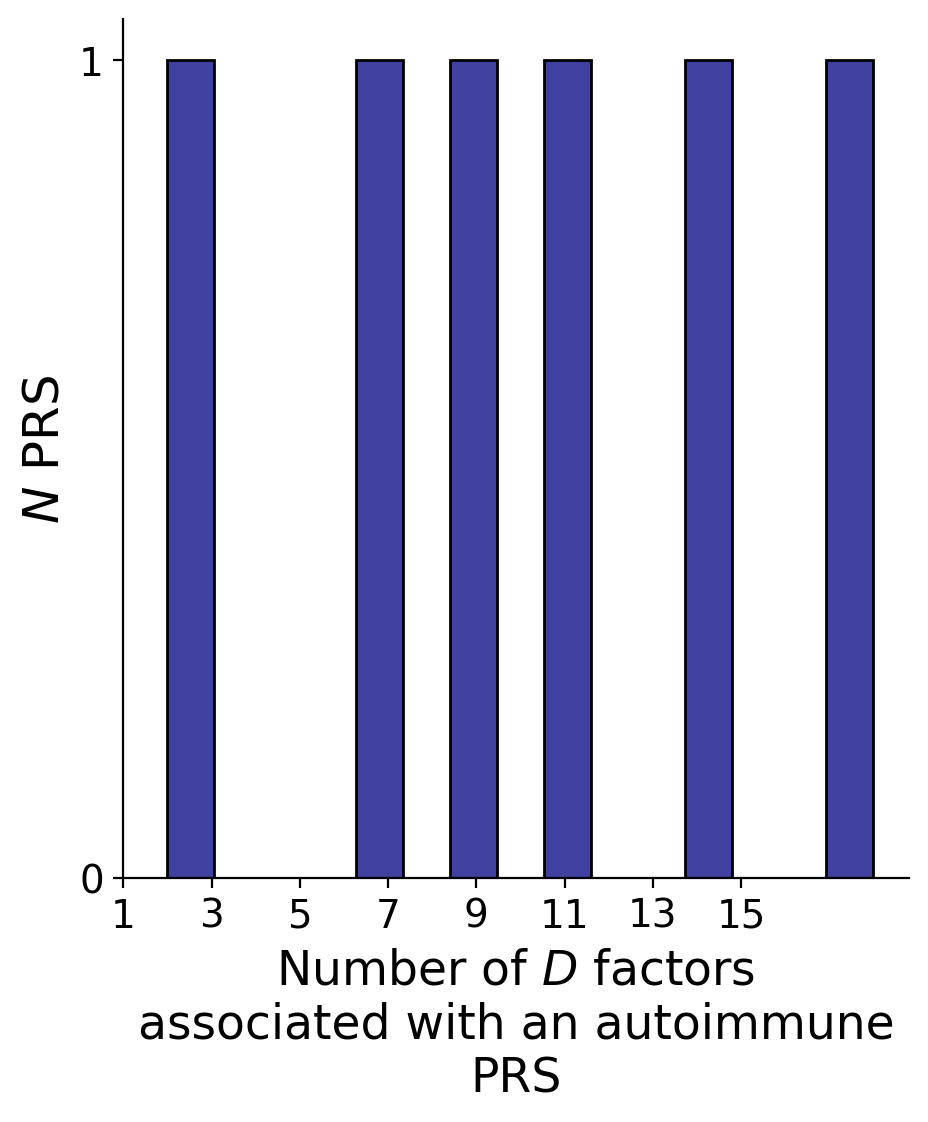

In [263]:
sns.displot(PRS_effects.loc[PRS_effects.SNP_id.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])
            ].groupby("SNP_id").apply(lambda x: x.Factor.nunique(), include_groups=False),
            kde=False, color="navy", bins=15)
# plt.title(textwrap.fill(model, 50) + "\n")
plt.xticks(ticks=np.arange(1,17,2), labels=np.arange(1,17,2), fontdict={"fontsize":14})
plt.xlabel(textwrap.fill("Number of $D$ factors associated with an autoimmune PRS", 30), fontsize=17)
plt.ylabel("$N$ PRS", fontsize=18)
plt.yticks(ticks=np.arange(0,2,1), labels=np.arange(0,2,1), fontdict={"fontsize":14})
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_D-factors_associated-with-autoimmune-PRS.png"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_D-factors_associated-with-autoimmune-PRS.eps"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_D-factors_associated-with-autoimmune-PRS.pdf"),
            transparent=True, bbox_inches="tight", dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


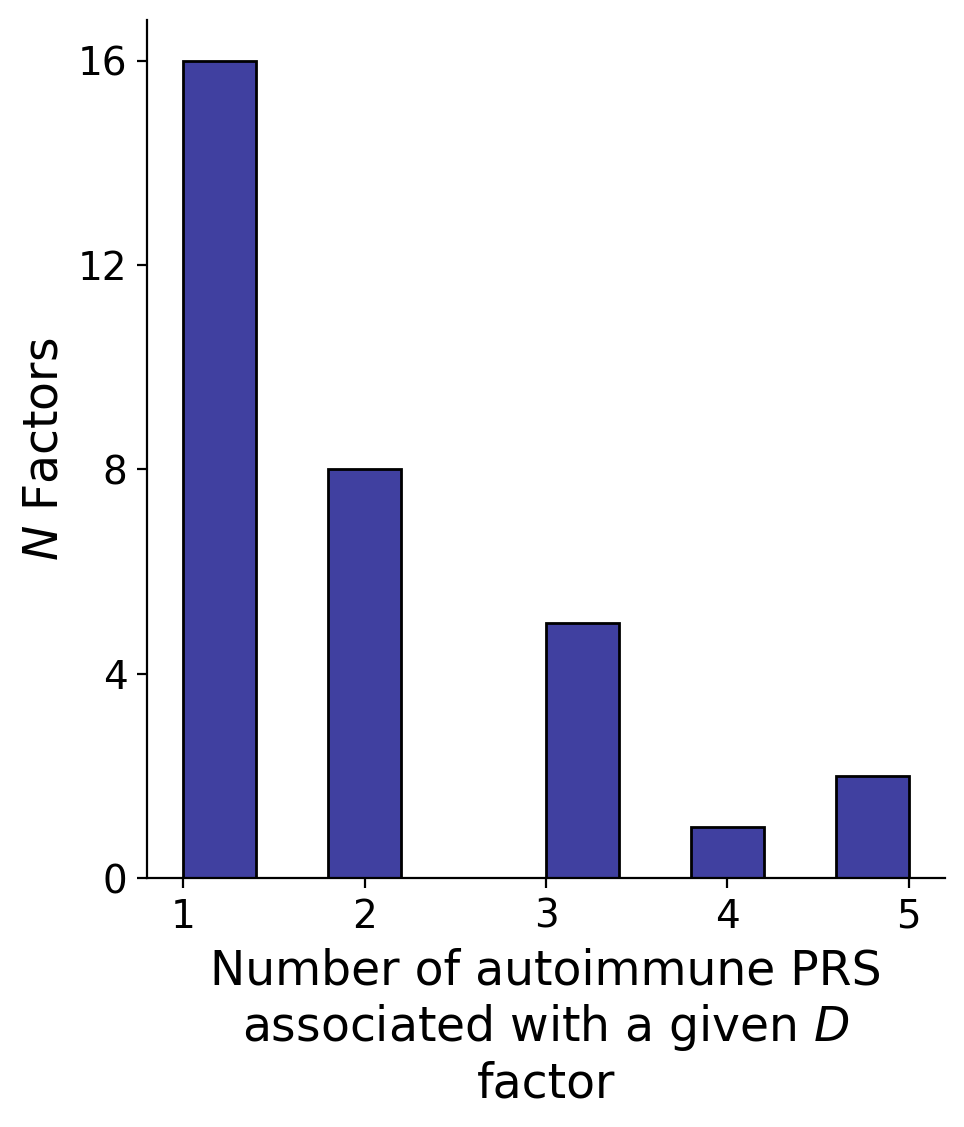

In [259]:
sns.displot(PRS_effects.loc[PRS_effects.SNP_id.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])
            ].groupby("Factor").apply(lambda x: x.SNP_id.nunique(), include_groups=False), color="navy", kde=False, bins=10)
# plt.xticks(ticks=np.arange(1,226,25), labels=np.arange(1,226,25), fontdict={"fontsize":13})
plt.xlabel(textwrap.fill("Number of autoimmune PRS associated with a given $D$ factor", 30), fontsize=17)
plt.ylabel("$N$ Factors", fontsize=17)
plt.yticks(ticks=np.arange(0,20,4), labels=np.arange(0,20,4), fontdict={"fontsize":14})
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_autoimmune-PRS_associated-with-a-given-D-factor.png"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_autoimmune-PRS_associated-with-a-given-D-factor.eps"),
            transparent=True, bbox_inches="tight", dpi=200)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_N_autoimmune-PRS_associated-with-a-given-D-factor.pdf"),
            transparent=True, bbox_inches="tight", dpi=200)


In [30]:
PRS_effects.loc[
PRS_effects.SNP_id.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])
].groupby("Factor").apply(lambda x: x.SNP_id.unique())

/tmp/ipykernel_1261514/4165936203.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Factor
D_Factor126                      [Psoriasis]
D_Factor144                      [Psoriasis]
D_Factor147                             [MS]
D_Factor19                         [CeD, RA]
D_Factor210                        [CeD, RA]
D_Factor293                [RA, T1D, UC, MS]
D_Factor308                        [CeD, MS]
D_Factor314                      [Psoriasis]
D_Factor325                        [CeD, MS]
D_Factor36                       [Psoriasis]
D_Factor376                      [Psoriasis]
D_Factor377                            [CeD]
D_Factor385                             [MS]
D_Factor388                      [Psoriasis]
D_Factor395                   [CeD, T1D, MS]
D_Factor41                         [CeD, RA]
D_Factor450                        [CeD, MS]
D_Factor454           [CeD, RA, T1D, UC, MS]
D_Factor465                      [Psoriasis]
D_Factor474                      [Psoriasis]
D_Factor484                    [CeD, RA, MS]
D_Factor503                            [CeD]
D_F

## Single-gene testing

In [242]:
prs_single_gene = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/All_celltypes_gene-level-testing-results_tensorQTL_PRS_significant_BH_005.tsv", sep="\t")
prs_single_gene 

PRS             gene       p_value  effect_size  \
0                    RA  ENSG00000237541  9.695591e-10     0.538064   
1    Multiple_sclerosis  ENSG00000206503  2.467539e-15    -0.145157   
2             Psoriasis  ENSG00000234745  2.132760e-27     0.255924   
3             Psoriasis  ENSG00000204525  4.412189e-07     0.110659   
4                   T1D  ENSG00000116198  1.042748e-06    -0.356039   
..                  ...              ...           ...          ...   
123  Multiple_sclerosis  ENSG00000237541  1.138665e-06    -0.505952   
124           Psoriasis  ENSG00000234745  9.135416e-09     0.164066   
125                 T1D  ENSG00000237541  1.073929e-16     0.861978   
126           Psoriasis  ENSG00000234745  2.628227e-09     0.187778   
127                RBDW  ENSG00000189403  1.027481e-06     0.247103   

     effect_size_se  celltype      Storey_q  BH_corrected_pvalue  \
0          0.087115    CD4-ET  6.574692e-05         6.574692e-05   
1          0.018034    CD4-ET  3.151968e-10         3.151968e-10   
2          0.022870    CD4-ET  7.809746e-22         7.809746e-22   
3          0.021759    CD4-ET  2.163826e-02         2.163826e-02   
4          0.072433    CD4-ET  4.545638e-02         4.545638e-02   
..              ...       ...           ...                  ...   
123        0.103139    Plasma  4.886209e-02         4.886209e-02   
124        0.028236    Plasma  5.702061e-04         5.702061e-04   
125        0.101536    Plasma  1.474693e-11         1.474693e-11   
126        0.031192  CD4-SOX4  1.739286e-04         1.739286e-04   
127        0.050187  CD4-SOX4  4.528647e-02         4.528647e-02   

     BY_corrected_pvalue  
0           1.058272e-03  
1           5.073453e-09  
2           1.257068e-20  
3           3.482926e-01  
4           7.316726e-01  
..                   ...  
123         7.864915e-01  
124         9.178121e-03  
125         2.373687e-10  
126         2.799580e-03  
127         7.289377e-01  

[128 rows x 9 columns]

In [243]:
prs_single_gene = prs_single_gene.merge(adata.var.GeneSymbol.reset_index().rename(columns={"Geneid":"gene"}), on="gene", how="left")
prs_single_gene.head()

PRS             gene       p_value  effect_size  \
0                  RA  ENSG00000237541  9.695591e-10     0.538064   
1  Multiple_sclerosis  ENSG00000206503  2.467539e-15    -0.145157   
2           Psoriasis  ENSG00000234745  2.132760e-27     0.255924   
3           Psoriasis  ENSG00000204525  4.412189e-07     0.110659   
4                 T1D  ENSG00000116198  1.042748e-06    -0.356039   

   effect_size_se celltype      Storey_q  BH_corrected_pvalue  \
0        0.087115   CD4-ET  6.574692e-05         6.574692e-05   
1        0.018034   CD4-ET  3.151968e-10         3.151968e-10   
2        0.022870   CD4-ET  7.809746e-22         7.809746e-22   
3        0.021759   CD4-ET  2.163826e-02         2.163826e-02   
4        0.072433   CD4-ET  4.545638e-02         4.545638e-02   

   BY_corrected_pvalue GeneSymbol  
0         1.058272e-03   HLA-DQA2  
1         5.073453e-09      HLA-A  
2         1.257068e-20      HLA-B  
3         3.482926e-01      HLA-C  
4         7.316726e-01     CEP104

In [244]:
prs_single_gene.loc[prs_single_gene.PRS == "RA"]

PRS             gene       p_value  effect_size  effect_size_se  \
0    RA  ENSG00000237541  9.695591e-10     0.538064        0.087115   
6    RA  ENSG00000196735  1.166233e-20     0.526064        0.055150   
7    RA  ENSG00000237541  5.665507e-48     1.219178        0.079149   
16   RA  ENSG00000196735  2.661722e-12     0.264000        0.037251   
17   RA  ENSG00000237541  4.050251e-28     0.852937        0.075109   
26   RA  ENSG00000237541  1.091954e-20     0.845939        0.088613   
32   RA  ENSG00000196735  8.754150e-33     0.389369        0.031432   
33   RA  ENSG00000237541  5.277646e-41     0.895102        0.063607   
48   RA  ENSG00000237541  1.941371e-12     0.364210        0.051060   
49   RA  ENSG00000198502  1.390480e-19    -0.161108        0.017410   
63   RA  ENSG00000237541  2.631005e-31     1.020135        0.084534   
70   RA  ENSG00000196735  3.479456e-12    -0.179477        0.025465   
71   RA  ENSG00000237541  8.114888e-11     0.364274        0.055421   
72   RA  ENSG00000198502  2.418952e-14    -0.183856        0.023735   
81   RA  ENSG00000196735  2.547271e-10     0.605593        0.094718   
82   RA  ENSG00000237541  1.016260e-31     1.011418        0.083152   
90   RA  ENSG00000196735  2.700941e-09     0.318577        0.053015   
91   RA  ENSG00000237541  4.078720e-43     1.213319        0.083542   
102  RA  ENSG00000196735  2.340639e-10     0.288981        0.045102   
103  RA  ENSG00000237541  1.225833e-39     1.107074        0.080155   
114  RA  ENSG00000237541  1.285836e-20     0.648549        0.068048   
122  RA  ENSG00000237541  4.624840e-37     1.301009        0.096895   

      celltype      Storey_q  BH_corrected_pvalue  BY_corrected_pvalue  \
0       CD4-ET  6.574692e-05         6.574692e-05         1.058272e-03   
6           NK  2.372508e-15         2.372508e-15         3.818824e-14   
7           NK  3.111895e-41         3.111895e-41         5.008952e-40   
16      CD4-NC  2.564921e-07         2.564921e-07         4.128535e-06   
17      CD4-NC  1.711295e-22         1.711295e-22         2.754525e-21   
26   CD8-S100B  2.306839e-15         2.306839e-15         3.713122e-14   
32      CD8-ET  8.013992e-27         8.013992e-27         1.289944e-25   
33      CD8-ET  9.662849e-35         9.662849e-35         1.555346e-33   
48        B-IN  1.904175e-07         1.904175e-07         3.064988e-06   
49        B-IN  2.386717e-14         2.386717e-14         3.841695e-13   
63      CD8-NC  1.806417e-25         1.806417e-25         2.907635e-24   
70       B-Mem  3.295107e-07         3.295107e-07         5.303853e-06   
71       B-Mem  6.367525e-06         6.367525e-06         1.024926e-04   
72       B-Mem  2.763997e-09         2.763997e-09         4.448970e-08   
81        NK-R  1.916631e-05         1.916631e-05         3.085037e-04   
82        NK-R  7.974310e-26         7.974310e-26         1.283557e-24   
90     Mono-NC  1.766127e-04         1.766127e-04         2.842785e-03   
91     Mono-NC  1.120160e-36         1.120160e-36         1.803026e-35   
102     Mono-C  1.785616e-05         1.785616e-05         2.874154e-04   
103     Mono-C  1.683284e-33         1.683284e-33         2.709439e-32   
114         DC  2.482622e-15         2.482622e-15         3.996064e-14   
122     Plasma  5.080575e-31         5.080575e-31         8.177769e-30   

    GeneSymbol  
0     HLA-DQA2  
6     HLA-DQA1  
7     HLA-DQA2  
16    HLA-DQA1  
17    HLA-DQA2  
26    HLA-DQA2  
32    HLA-DQA1  
33    HLA-DQA2  
48    HLA-DQA2  
49    HLA-DRB5  
63    HLA-DQA2  
70    HLA-DQA1  
71    HLA-DQA2  
72    HLA-DRB5  
81    HLA-DQA1  
82    HLA-DQA2  
90    HLA-DQA1  
91    HLA-DQA2  
102   HLA-DQA1  
103   HLA-DQA2  
114   HLA-DQA2  
122   HLA-DQA2

In [245]:
prs_single_gene.loc[(prs_single_gene.GeneSymbol == "HLA-DQA2") & (prs_single_gene.celltype == "NK")]

PRS             gene       p_value  effect_size  \
7                   RA  ENSG00000237541  5.665507e-48     1.219178   
11  Multiple_sclerosis  ENSG00000237541  1.180216e-09    -0.523855   
14                 T1D  ENSG00000237541  1.501903e-14     0.674162   

    effect_size_se celltype      Storey_q  BH_corrected_pvalue  \
7         0.079149       NK  3.111895e-41         3.111895e-41   
11        0.085262       NK  7.905584e-05         7.905584e-05   
14        0.086318       NK  1.755215e-09         1.755215e-09   

    BY_corrected_pvalue GeneSymbol  
7          5.008952e-40   HLA-DQA2  
11         1.272494e-03   HLA-DQA2  
14         2.825219e-08   HLA-DQA2

In [247]:
prs_single_gene.PRS.nunique()

13

In [248]:
prs_single_gene.PRS.unique()

array(['RA', 'Multiple_sclerosis', 'Psoriasis', 'T1D', 'Celiac',
       'Hair_color', 'Platelet_count', 'PDW', 'UC', 'RBDW', 'T2D',
       'Monocyte_percentage', 'IBD'], dtype=object)

In [250]:
prs_single_gene.loc[prs_single_gene.PRS == "Hair_color"]

PRS             gene       p_value  effect_size  effect_size_se  \
8   Hair_color  ENSG00000117010  2.684146e-07     0.402548        0.077687   
50  Hair_color  ENSG00000126106  1.066398e-07     0.514207        0.096004   

   celltype  Storey_q  BH_corrected_pvalue  BY_corrected_pvalue GeneSymbol  
8        NK  0.013526             0.013526             0.217715     ZNF684  
50     B-IN  0.005578             0.005578             0.089792     TMEM53

# LIVI results

In [31]:
PRS_colors = dict(
    zip(["CeD", "MS", "Psoriasis", "RA", "T1D", "UC"],
        sns.color_palette("Set2", 6))
)
PRS_colors 

{'CeD': (0.4, 0.7607843137254902, 0.6470588235294118),
 'MS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'Psoriasis': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'RA': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'T1D': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 'UC': (1.0, 0.8509803921568627, 0.1843137254901961)}

In [32]:
PRS_colors_dark = dict(
    zip(["CeD", "MS", "Psoriasis", "RA", "T1D", "UC"],
        ["peru", "royalblue", "slateblue", "darkred", "darkgreen", "mediumseagreen"])
) 

In [33]:
PRS_effects.groupby("SNP_id").apply(lambda x: x.Factor.nunique())

/tmp/ipykernel_1261514/1030827017.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


SNP_id
CeD                 18
Lymphocyte_count     1
MS                  14
Psoriasis           11
RA                   9
RBC                  1
RBDW                 2
T1D                  7
T2D                  1
UC                   2
dtype: int64

In [35]:
PRS_effects.nlargest(3, columns="effect_size", keep="all")

Factor     SNP_id  effect_size  effect_size_se       p_value  \
16  D_Factor293         RA     0.429920        0.033767  2.003210e-40   
10  D_Factor126  Psoriasis     0.370971        0.041848  1.425287e-19   
7    D_Factor72        CeD     0.337784        0.031566  2.603542e-28   

    corrected_pvalue                    fPRS  
16      1.028314e-36         RA__D_Factor293  
10      2.194942e-16  Psoriasis__D_Factor126  
7       6.682424e-25         CeD__D_Factor72

In [36]:
PRS_effects.nsmallest(5, columns="effect_size", keep="all")

Factor     SNP_id  effect_size  effect_size_se        p_value  \
38  D_Factor454         RA    -0.448254        0.022657  1.232558e-110   
8    D_Factor72         RA    -0.434800        0.029862   6.977421e-54   
53  D_Factor661  Psoriasis    -0.361534        0.039125   3.339088e-21   
20  D_Factor308        CeD    -0.334436        0.042142   7.147283e-16   
4    D_Factor41         RA    -0.273531        0.025460   1.545146e-28   

    corrected_pvalue                    fPRS  
38     1.898139e-106         RA__D_Factor454  
8       5.372614e-50          RA__D_Factor72  
53      6.427745e-18  Psoriasis__D_Factor661  
20      7.862012e-13        CeD__D_Factor308  
4       4.759051e-25          RA__D_Factor41

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


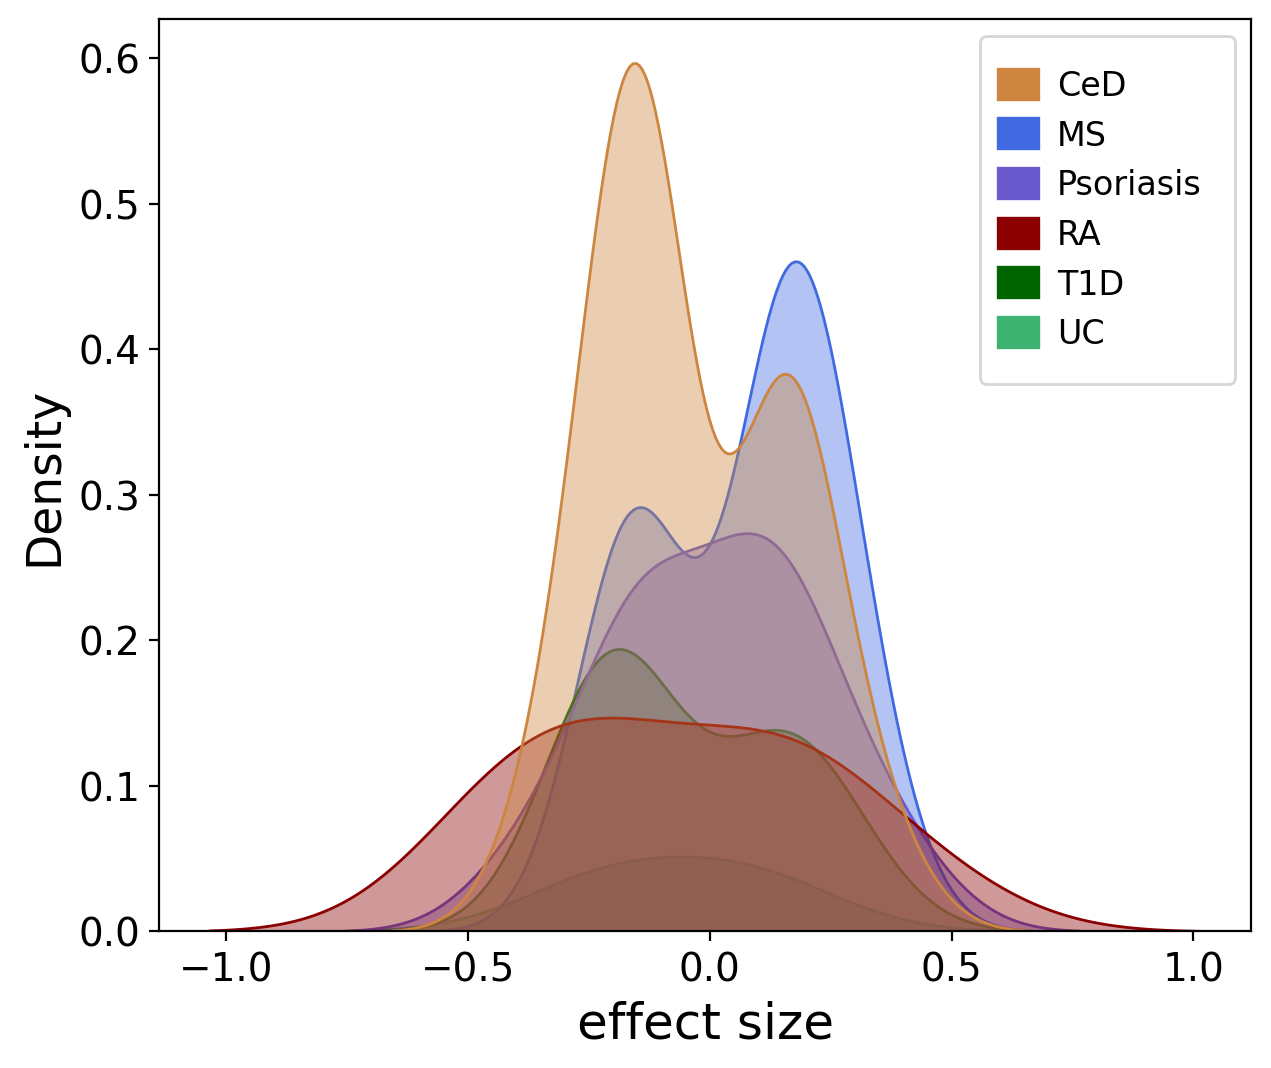

In [1579]:
fig, axs = plt.subplots(constrained_layout=False)

sns.kdeplot(data=PRS_effects.loc[PRS_effects.SNP_id.isin(["MS", "CeD", "T1D", "RA", "Psoriasis", "UC"])].drop(columns=["Celltype"]).drop_duplicates(), 
                 x="effect_size", hue="SNP_id", alpha=0.4, palette=PRS_colors_dark, fill=True, ax=axs)
axs.set_xlabel("effect size", fontsize=18)
axs.set_ylabel("Density", fontsize=17)

legend_handles = []
for D, cD in PRS_colors_dark.items():
    legend_handles.append(Line2D([0], [0], color=cD, lw=12, label=D))
    
axs.legend(handles=legend_handles, fontsize=12, handlelength=0.3, handletextpad=1, borderpad=1)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associations_effect-size-KDEplot_colored-by-PRS.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associations_effect-size-KDEplot_colored-by-PRS.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associations_effect-size-KDEplot_colored-by-PRS.png"), 
            transparent=True, dpi=400, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


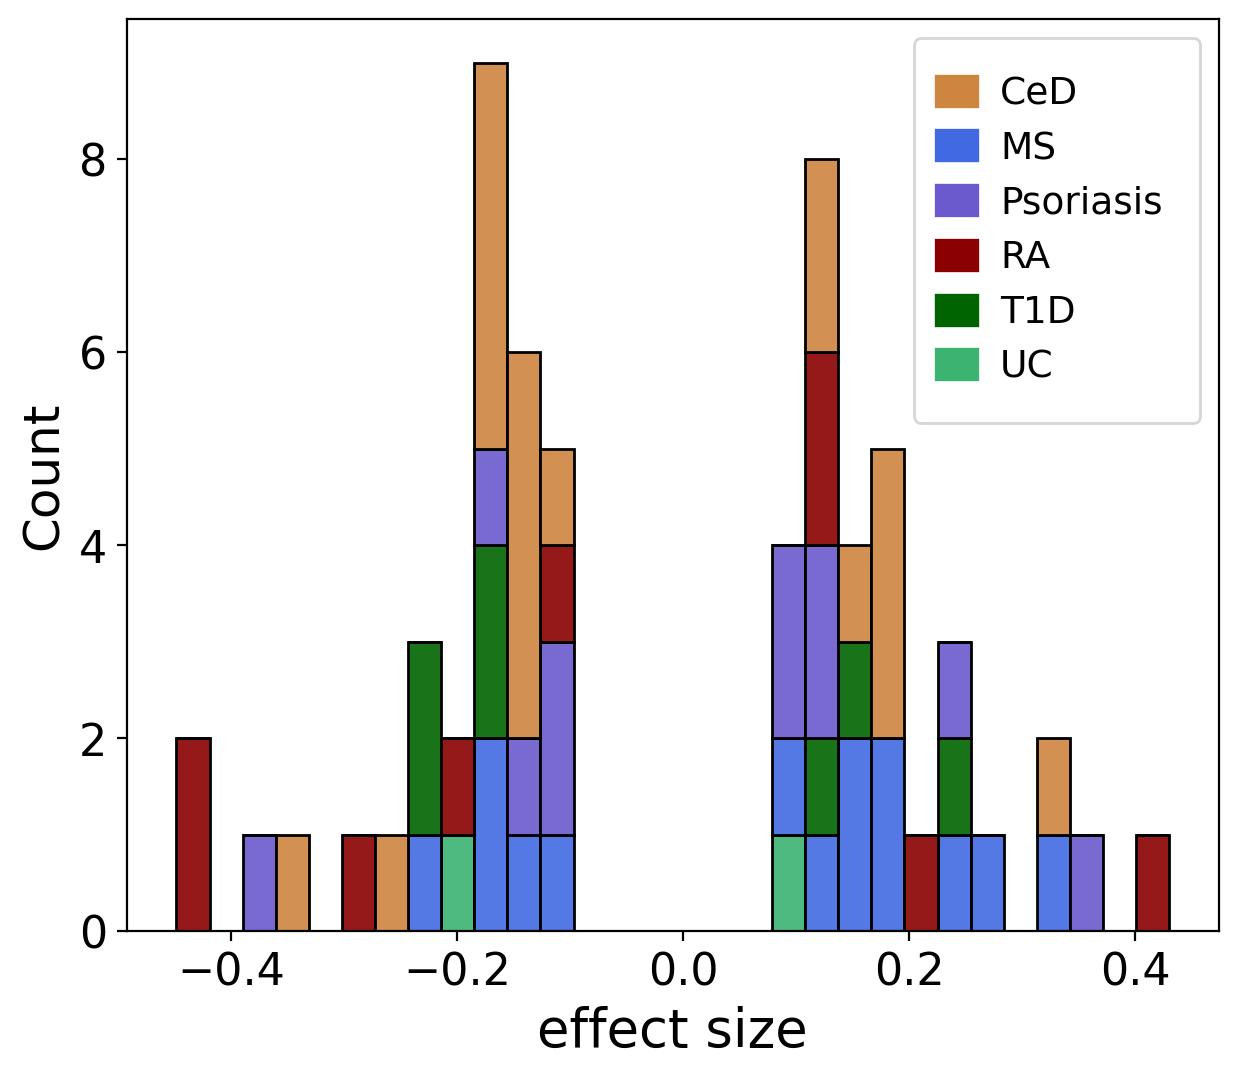

In [1671]:
fig, axs = plt.subplots(constrained_layout=False)

sns.histplot(data=PRS_effects.loc[PRS_effects.SNP_id.isin(["MS", "CeD", "T1D", "RA", "Psoriasis", "UC"])].drop(columns=["Celltype"]).drop_duplicates(), 
                 x="effect_size", hue="SNP_id", bins=30, alpha=0.9, palette=PRS_colors_dark, multiple="stack", ax=axs)

axs.set_xlabel("effect size", fontsize=19)
axs.set_ylabel("Count", fontsize=18)
axs.tick_params(axis="both", which="major", labelsize=16)

legend_handles = []
for D, cD in PRS_colors_dark.items():
    legend_handles.append(Line2D([0], [0], color=cD, lw=12, label=D))
    
axs.legend(handles=legend_handles, fontsize=13.5, handlelength=0.3, handletextpad=1, borderpad=1)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associations_effect-size-Histplot_colored-by-PRS.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associations_effect-size-Histplot_colored-by-PRS.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associations_effect-size-Histplot_colored-by-PRS.png"), 
            transparent=True, dpi=400, bbox_inches="tight")

### Scatterplots of D factors colored by PRS

In [44]:
tmp = D.filter(PRS_effects.Factor)
tmp = tmp.merge(PRS, right_index=True, left_index=True, how="left")
tmp

D_Factor19  D_Factor36  D_Factor41  D_Factor69  D_Factor72  \
individual                                                               
691_692       0.123229    0.705303    1.854355   -0.324754    1.797535   
693_694       2.047674   -1.734437   -0.180548    0.041680   -0.769870   
688_689       0.984981   -0.688939    1.634096   -1.553127    1.994873   
683_684       0.059177    1.016745   -0.101119    0.254557   -0.135661   
684_685      -1.115713   -0.700316    0.166186   -0.040473    1.347377   
...                ...         ...         ...         ...         ...   
840_841       0.335624    1.124358   -0.630552   -0.267876    0.755155   
801_802       0.967749   -0.998454    1.120464    2.751076    0.385059   
797_798       0.331820   -0.958138   -0.084024   -0.972840    0.616998   
798_799       0.242178   -0.885959    0.650910   -0.208510    1.044585   
822_823      -0.713107   -1.206519   -1.561158   -0.510651   -0.639076   

            D_Factor126  D_Factor144  D_Factor147  D_Factor210  D_Factor223  \
individual                                                                    
691_692        1.440416    -0.234058     0.037699    -4.273785     1.128427   
693_694        2.011178    -0.090131    -0.362218     0.569802    -0.681610   
688_689       -0.403126    -0.512309    -0.243749     2.270372     0.222401   
683_684        0.492243    -0.816543     2.851629    -0.613692    -0.739146   
684_685       -0.216282    -0.182701     0.844044    -0.421337     1.483429   
...                 ...          ...          ...          ...          ...   
840_841        0.280637    -0.372132     0.390900     1.747408     0.998085   
801_802       -1.881693     0.284520     4.646238    -0.536917    -1.456537   
797_798       -1.183620    -0.169536    -1.491386     0.557510    -3.360758   
798_799       -0.214294    -0.145548    -1.620802     0.979772     2.202671   
822_823        0.380891    -0.194444     0.192900    -0.278413     1.550821   

            ...    Height  Platelet_count       RBC  Leukocyte_count  \
individual  ...                                                        
691_692     ... -0.144022        0.684278 -0.251568         1.168590   
693_694     ... -0.459942       -0.073953  1.521804         0.880476   
688_689     ... -0.389158       -0.044611  1.307181         1.319138   
683_684     ... -1.586118        0.493378 -0.344106         0.281813   
684_685     ... -0.554570       -0.548276  0.662240         0.370617   
...         ...       ...             ...       ...              ...   
840_841     ...  0.731011       -0.238728  1.173662         0.761485   
801_802     ... -0.174954       -0.015106 -0.315019        -0.172859   
797_798     ...  1.726136        1.443055 -0.393431        -1.030489   
798_799     ...  0.368221        0.408100  0.632839         0.716633   
822_823     ... -0.991591       -0.641139  0.223589         0.293692   

                RBDW        UC  Lymphocyte_count       T2D  Endometriosis  \
individual                                                                  
691_692    -2.590094 -0.338635          1.010230  1.255989       0.183071   
693_694    -0.007997 -0.743467          0.258249 -0.445195       0.306532   
688_689    -0.096182 -2.242711          0.076434  0.921082      -1.115088   
683_684     0.221220 -0.326834          0.806733 -0.695708      -1.368122   
684_685     2.396896  0.741925         -0.392671  0.033624      -0.253174   
...              ...       ...               ...       ...            ...   
840_841     0.017823 -0.419462         -0.098836  0.856233      -0.628667   
801_802    -1.273162  0.098815          0.178686 -0.114730      -0.508913   
797_798    -1.562931  1.745476         -0.040868  0.731864      -0.484769   
798_799     0.933896  0.791116          0.084450  0.383633      -1.306555   
822_823    -0.353566 -0.255800          1.327735  0.686559      -0.629124   

            Multiple_sclerosis  
individual                      
691_692         

In [45]:
tmp = tmp.merge(adata.obs.filter(["individual", "sex", "latent"]).drop_duplicates().set_index("individual"), right_index=True, left_index=True)

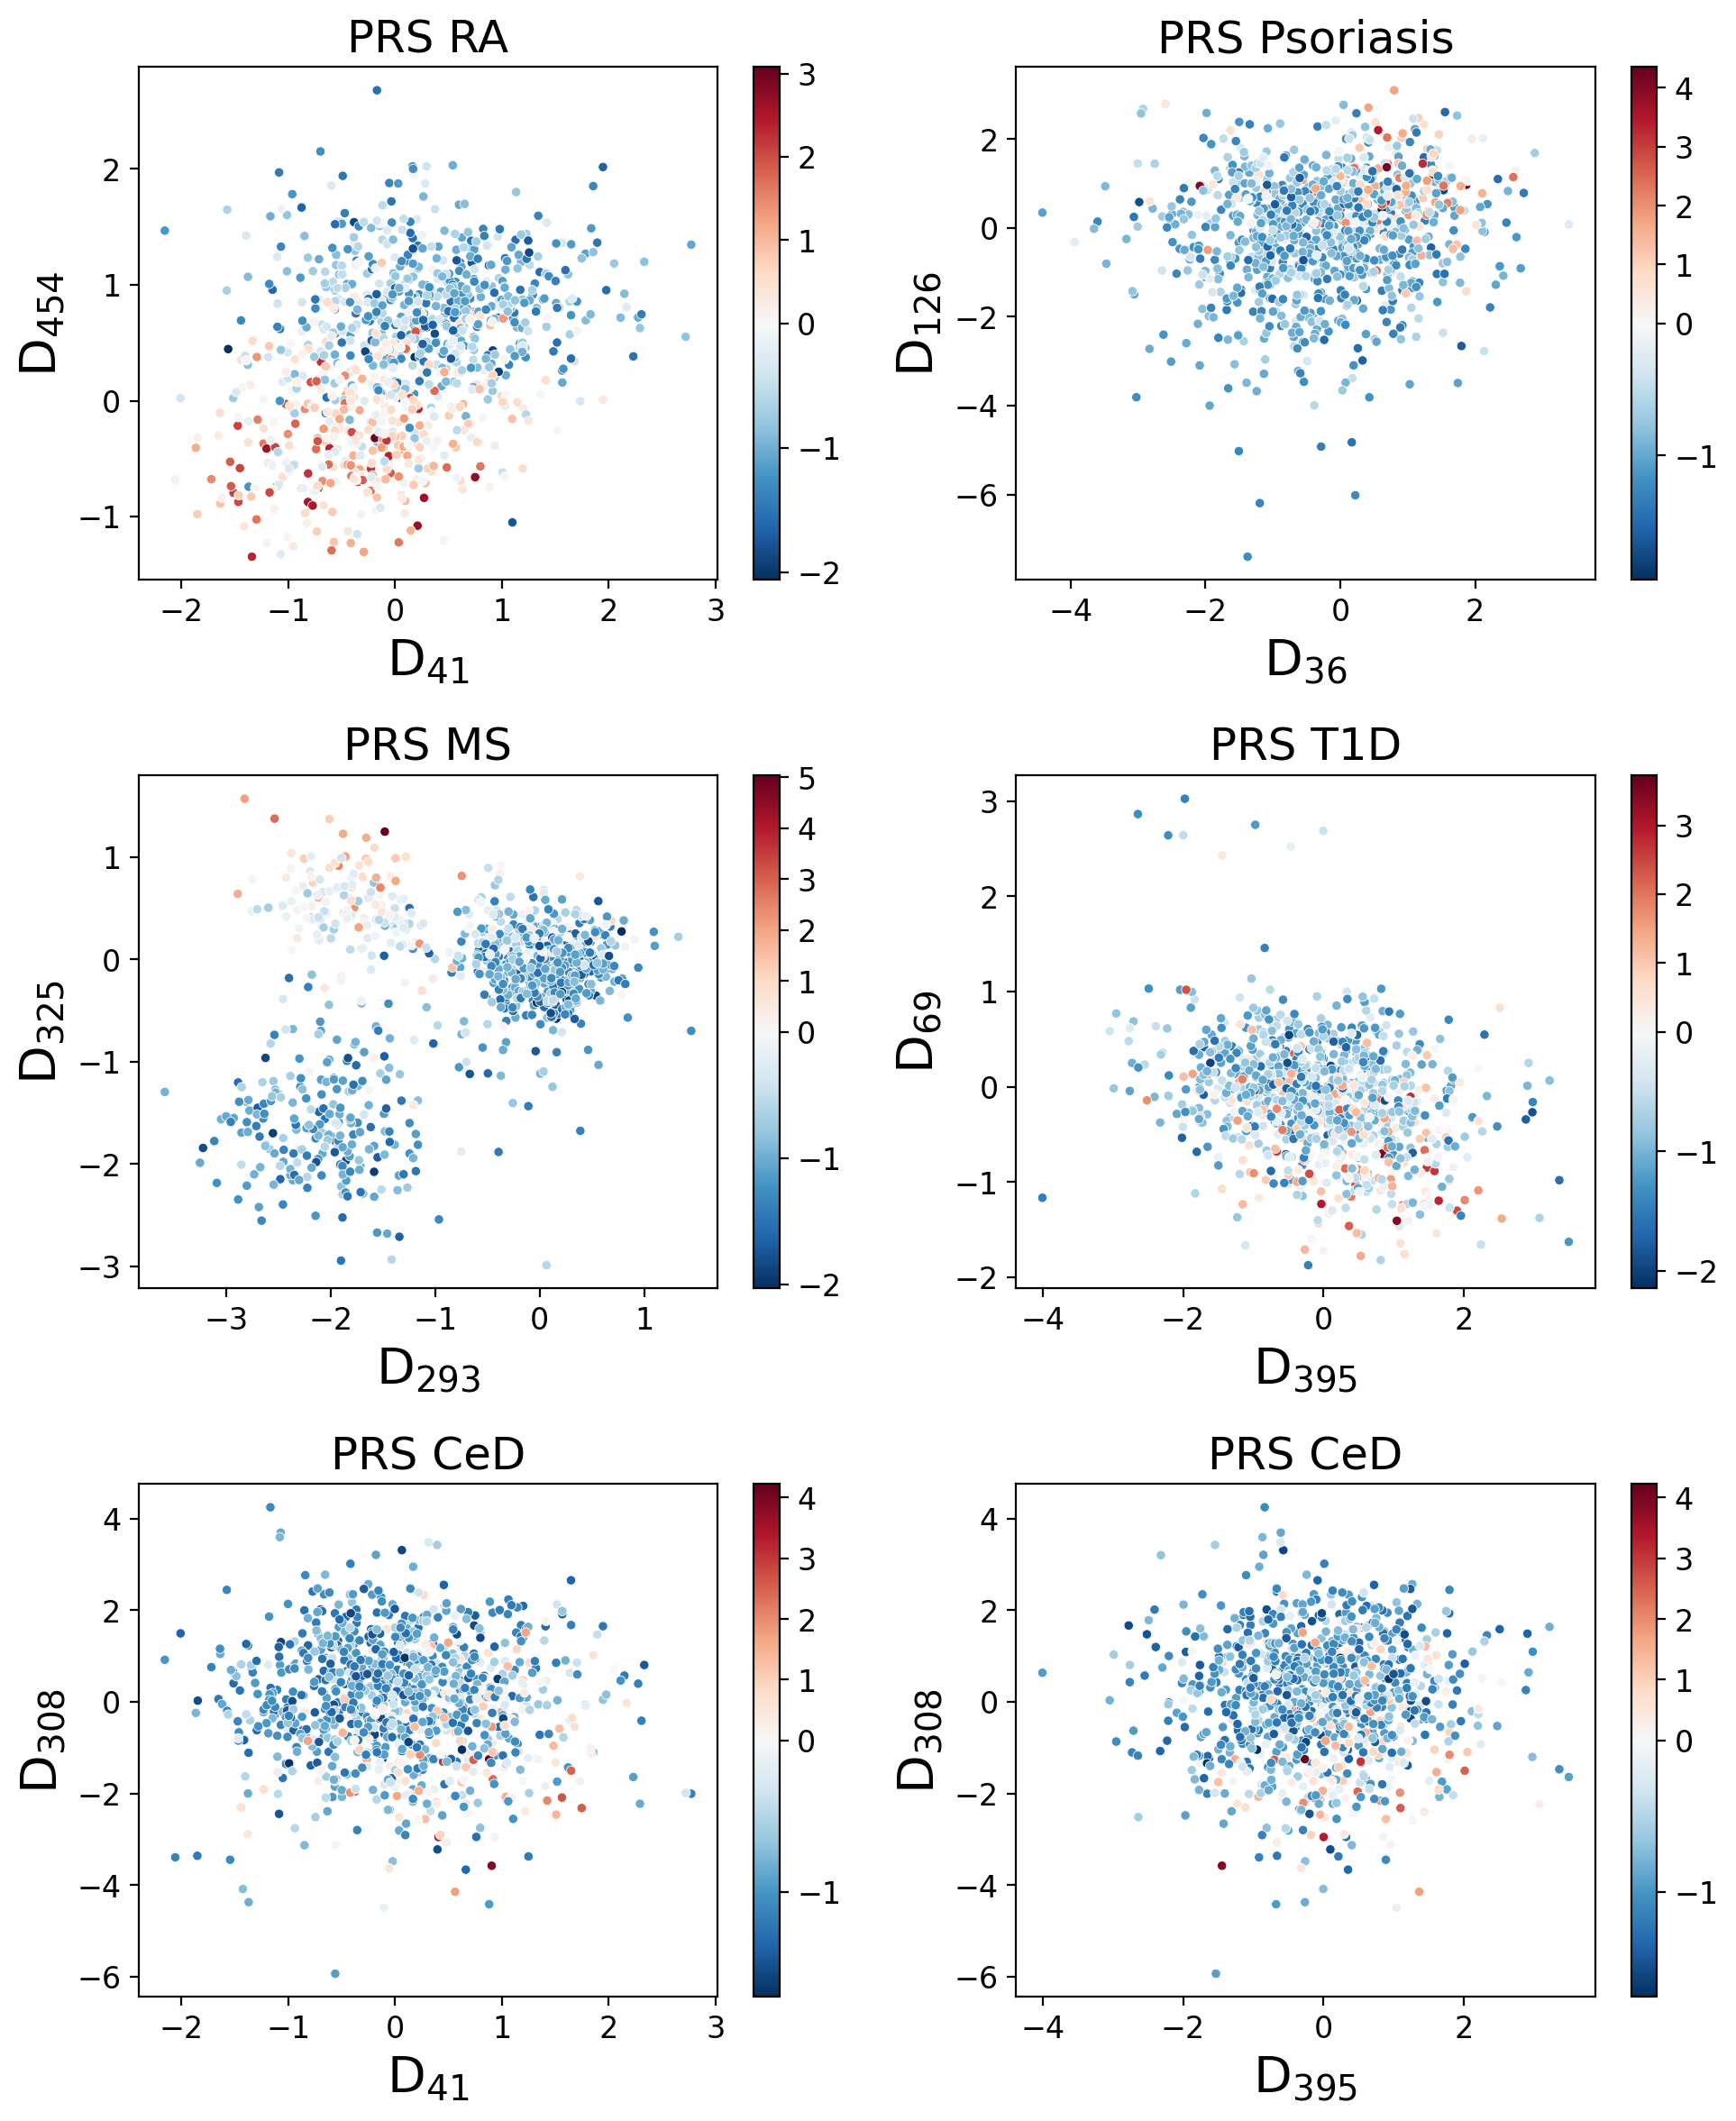

In [56]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,12), constrained_layout=False)
axs = axs.flatten()

sns.scatterplot(x="D_Factor41", y="D_Factor454", hue="RA", data=tmp, ax=axs[0], s=14, palette="RdBu_r", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.RA.min(), vmax=tmp.RA.max()))
cb = plt.colorbar(sm, ax=axs[0])
axs[0].set_title(label="PRS RA", fontdict={'fontsize':18}, loc='center')
axs[0].set_xlabel("D$_{41}$")
axs[0].set_ylabel("D$_{454}$")
cb.ax.tick_params(labelsize=12)


sns.scatterplot(x="D_Factor36", y="D_Factor126", hue="Psoriasis", data=tmp, ax=axs[1], s=14, palette="RdBu_r", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.Psoriasis.min(), vmax=tmp.Psoriasis.max()))
cb = plt.colorbar(sm, ax=axs[1])
axs[1].set_title(label="PRS Psoriasis", fontdict={'fontsize':18}, loc='center')
axs[1].set_xlabel("D$_{36}$")
axs[1].set_ylabel("D$_{126}$")
cb.ax.tick_params(labelsize=12) 


sns.scatterplot(x="D_Factor293", y="D_Factor325", hue="Multiple_sclerosis", data=tmp, ax=axs[2], s=14, palette="RdBu_r", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.Multiple_sclerosis.min(), vmax=tmp.Multiple_sclerosis.max()))
cb = plt.colorbar(sm, ax=axs[2])
axs[2].set_title(label="PRS MS", fontdict={'fontsize':18}, loc='center')
axs[2].set_xlabel("D$_{293}$")
axs[2].set_ylabel("D$_{325}$")
cb.ax.tick_params(labelsize=12) 


sns.scatterplot(x="D_Factor395", y="D_Factor69", hue="T1D", data=tmp, ax=axs[3], s=14, palette="RdBu_r", legend=False)
# sns.scatterplot(x="U_Factor293", y="U_Factor69", hue="T1D", data=tmp, ax=axs[3], s=12, palette="vlag", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.T1D.min(), vmax=tmp.T1D.max()))
cb = plt.colorbar(sm, ax=axs[3])
axs[3].set_title(label="PRS T1D", fontdict={'fontsize':18}, loc='center')
axs[3].set_xlabel("D$_{395}$")
axs[3].set_ylabel("D$_{69}$")
cb.ax.tick_params(labelsize=12) 


# sns.scatterplot(x="D_Factor454", y="D_Factor325", hue="Multiple_sclerosis", data=tmp, ax=axs[4], s=14, palette="RdBu_r", legend=False)
# sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.Multiple_sclerosis.min(), vmax=tmp.Multiple_sclerosis.max()))
# cb = plt.colorbar(sm, ax=axs[4])
# axs[4].set_title(label="PRS MS", fontdict={'fontsize':18}, loc='center')
# axs[4].set_xlabel("D$_{454}$")
# axs[4].set_ylabel("D$_{325}$")
# cb.ax.tick_params(labelsize=12) 
sns.scatterplot(x="D_Factor41", y="D_Factor308", hue="Celiac", data=tmp, ax=axs[4], s=14, palette="RdBu_r", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.Celiac.min(), vmax=tmp.Celiac.max()))
cb = plt.colorbar(sm, ax=axs[4])
axs[4].set_title(label="PRS CeD", fontdict={'fontsize':18}, loc='center')
axs[4].set_xlabel("D$_{41}$")
axs[4].set_ylabel("D$_{308}$")
cb.ax.tick_params(labelsize=12) 


sns.scatterplot(x="D_Factor395", y="D_Factor308", hue="Celiac", data=tmp, ax=axs[5], s=14, palette="RdBu_r", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.Celiac.min(), vmax=tmp.Celiac.max()))
cb = plt.colorbar(sm, ax=axs[5])
axs[5].set_title(label="PRS CeD", fontdict={'fontsize':18}, loc='center')
axs[5].set_xlabel("D$_{395}$")
axs[5].set_ylabel("D$_{308}$")
cb.ax.tick_params(labelsize=12) 


for ax in axs:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
    ax.tick_params(labelsize=12)

# fig.delaxes(axs[-1])

plt.tight_layout()

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_context-effects_PRS2.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_context-effects_PRS2.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

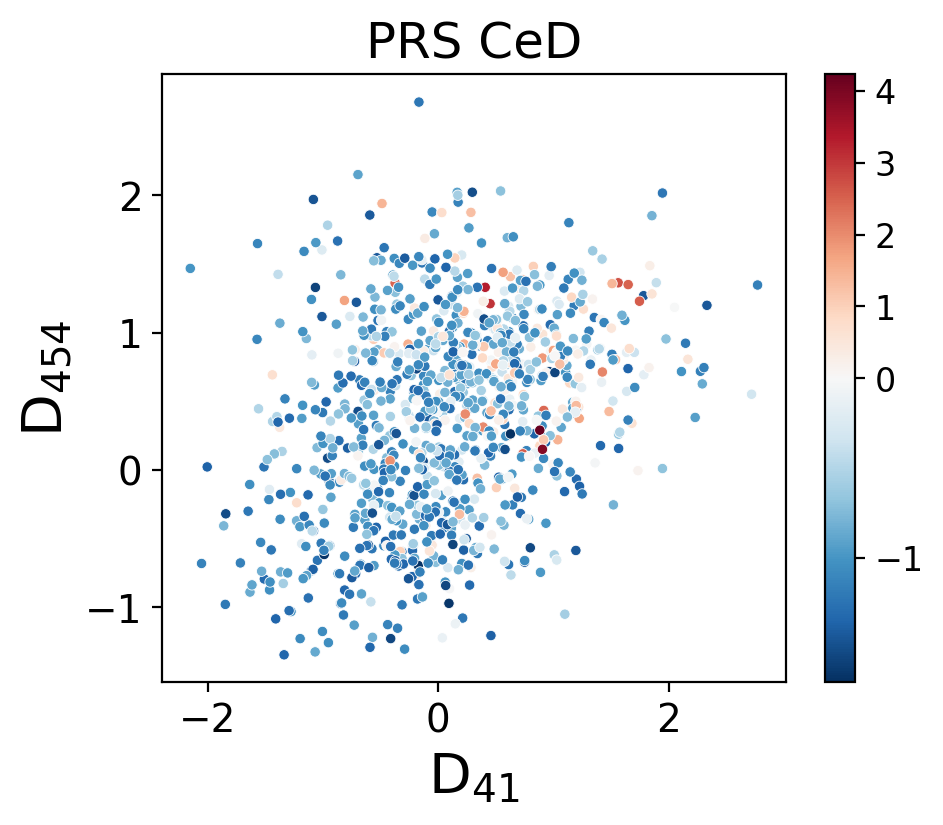

In [188]:
fig, axs = plt.subplots(figsize=(5,4), constrained_layout=False)

sns.scatterplot(x="D_Factor41", y="D_Factor454", hue="Celiac", data=tmp, ax=axs, s=14, palette="RdBu_r", legend=False)
sm = cm.ScalarMappable(cmap="RdBu_r", norm=colors.TwoSlopeNorm(vcenter=0.0, vmin=tmp.Celiac.min(), vmax=tmp.Celiac.max()))
cb = plt.colorbar(sm, ax=axs)
axs.set_title(label="PRS CeD", fontdict={'fontsize':18}, loc="center")
axs.set_xlabel("D$_{41}$", fontsize=20)
axs.set_ylabel("D$_{454}$", fontsize=20)
cb.ax.tick_params(labelsize=12) 

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_D41_vs_D454_color-PRS-Celiac.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_D41_vs_D454_color-PRS-Celiac.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_D41_vs_D454_color-PRS-Celiac.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


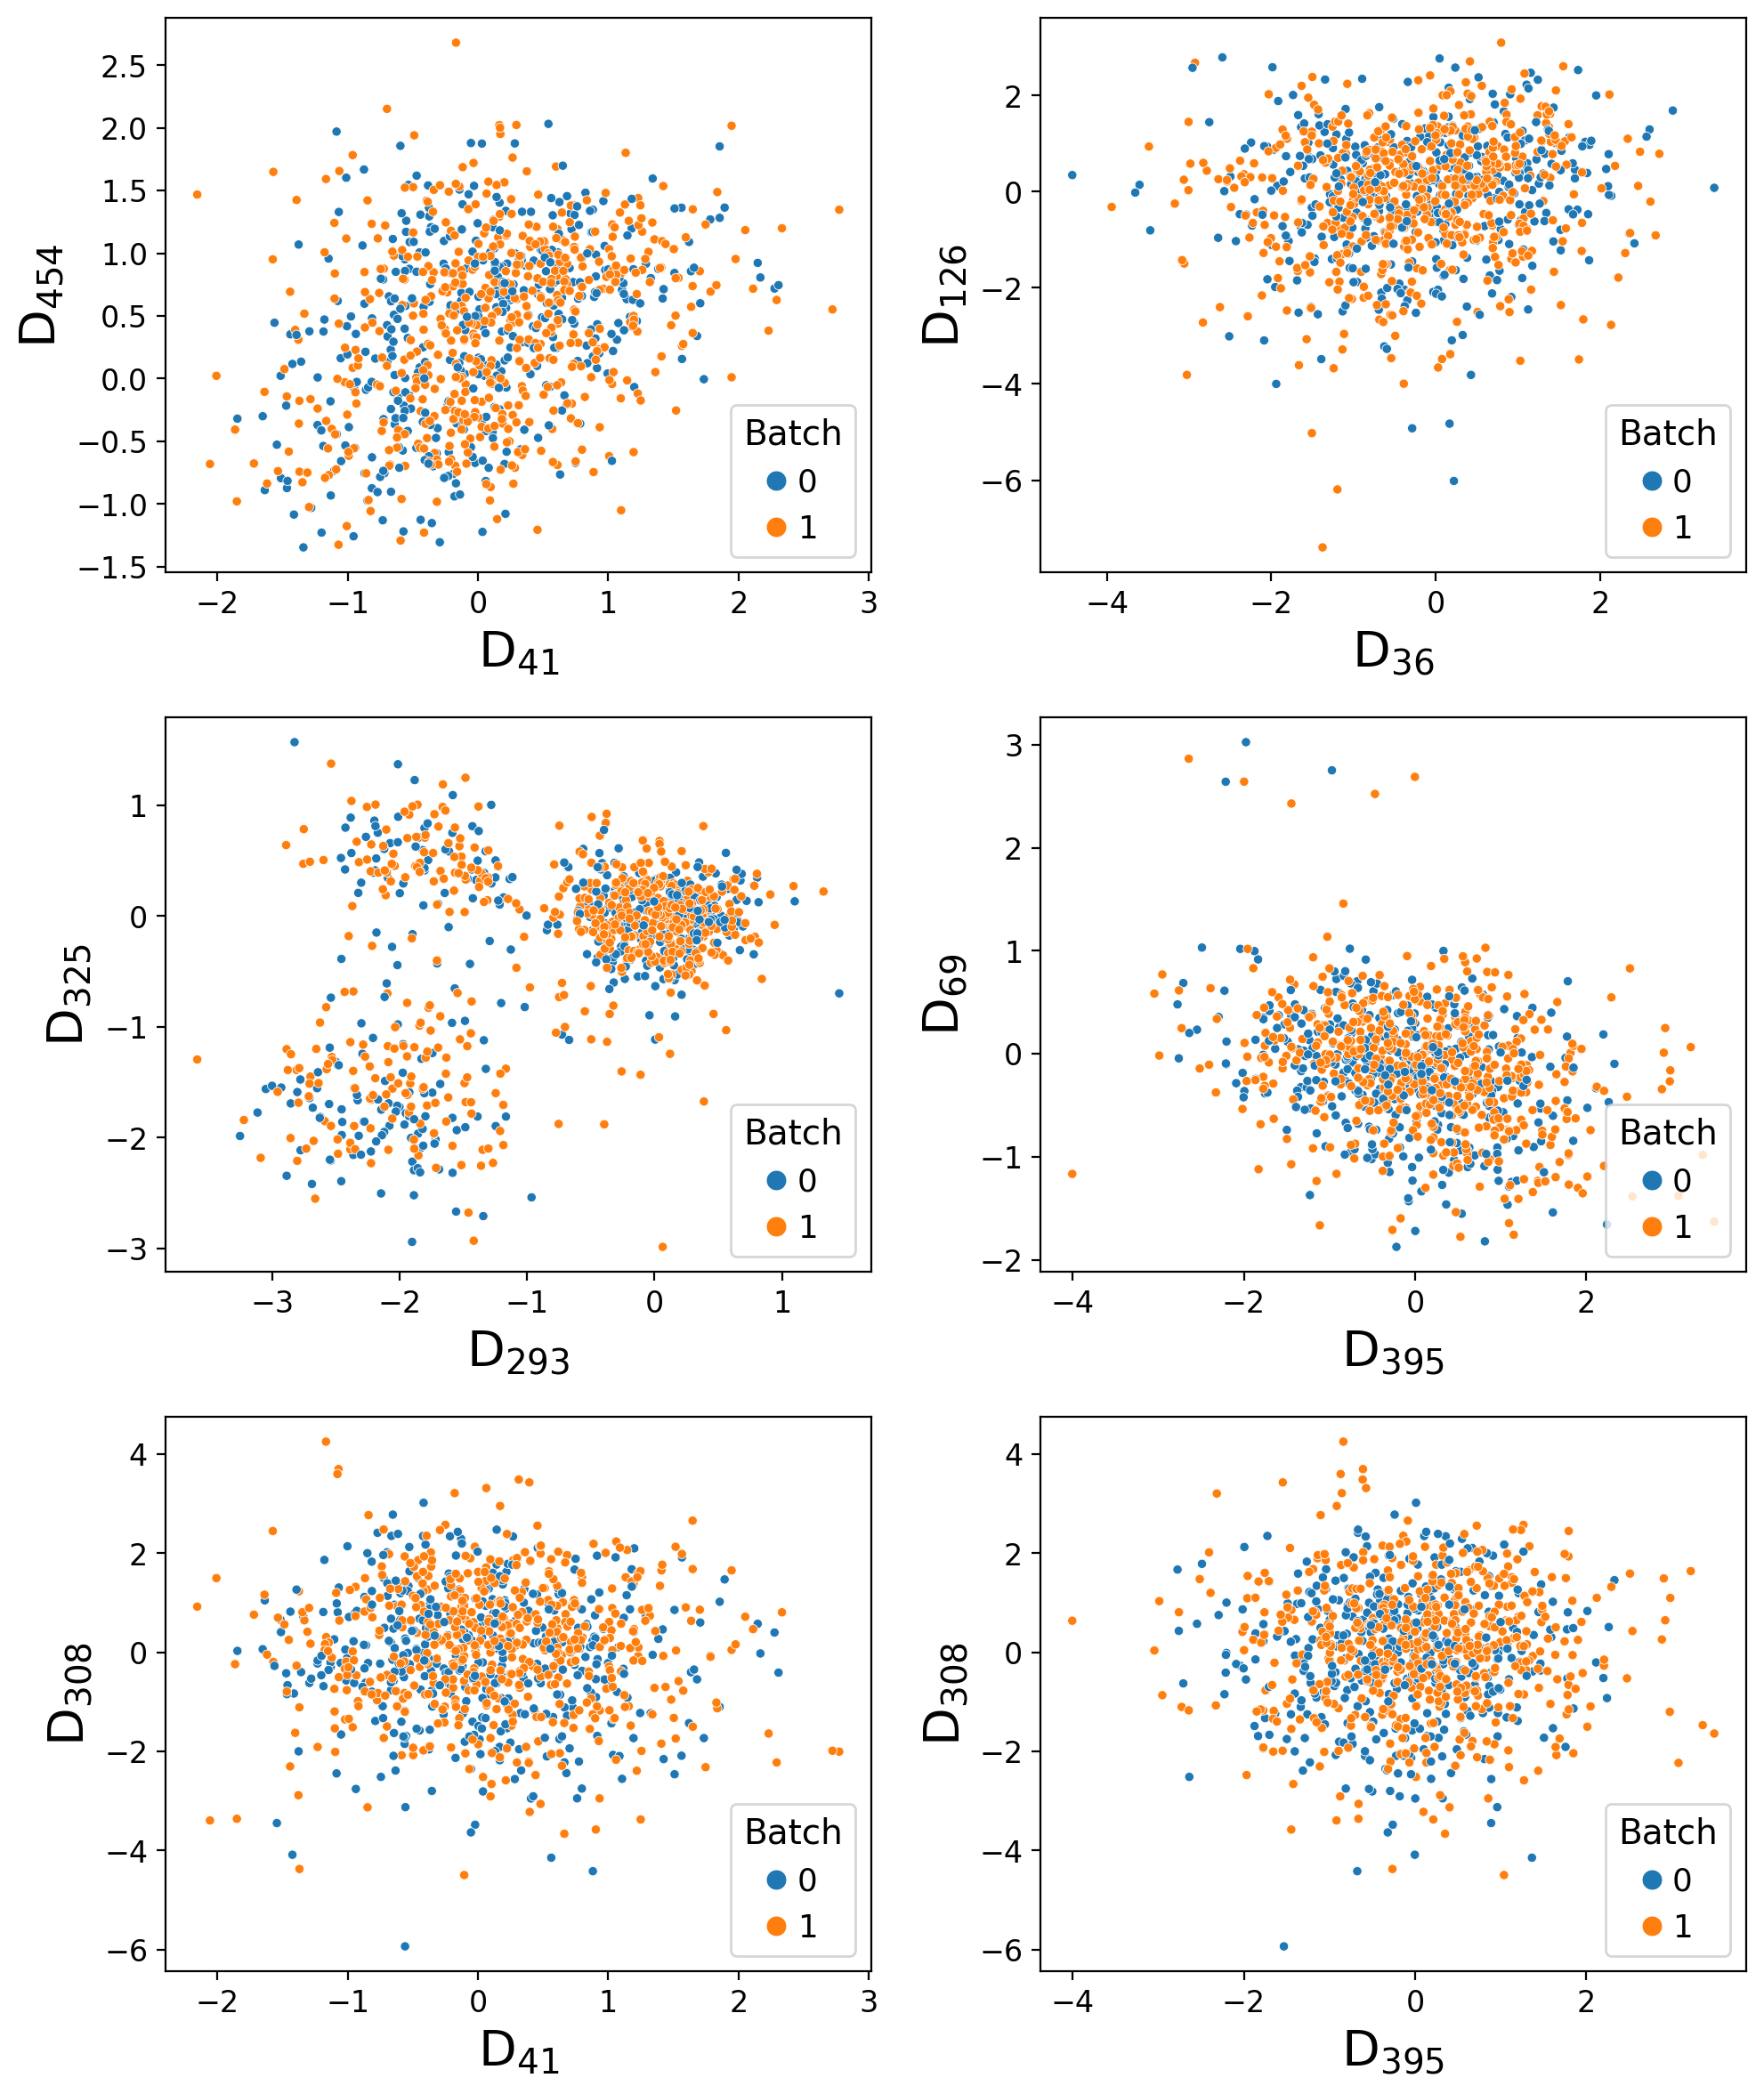

In [57]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,12), constrained_layout=False)
axs = axs.flatten()

sns.scatterplot(x="D_Factor41", y="D_Factor454", hue="latent", data=tmp, ax=axs[0], s=14)
axs[0].legend(title="Batch", markerscale=2.2, loc="lower right")
axs[0].set_xlabel("D$_{41}$")
axs[0].set_ylabel("D$_{454}$")


sns.scatterplot(x="D_Factor36", y="D_Factor126", hue="latent", data=tmp, ax=axs[1], s=14)
axs[1].legend(title="Batch", markerscale=2.2, loc="lower right")
axs[1].set_xlabel("D$_{36}$")
axs[1].set_ylabel("D$_{126}$")


sns.scatterplot(x="D_Factor293", y="D_Factor325", hue="latent", data=tmp, ax=axs[2], s=14)
axs[2].legend(title="Batch", markerscale=2.2, loc="lower right")
axs[2].set_xlabel("D$_{293}$")
axs[2].set_ylabel("D$_{325}$")


sns.scatterplot(x="D_Factor395", y="D_Factor69", hue="latent", data=tmp, ax=axs[3], s=14)
axs[3].legend(title="Batch", markerscale=2.2, loc="lower right")
axs[3].set_xlabel("D$_{395}$")
axs[3].set_ylabel("D$_{69}$")


sns.scatterplot(x="D_Factor41", y="D_Factor308", hue="latent", data=tmp, ax=axs[4], s=14)
axs[4].legend(title="Batch", markerscale=2.2, loc="lower right")
axs[4].set_xlabel("D$_{41}$")
axs[4].set_ylabel("D$_{308}$")


sns.scatterplot(x="D_Factor395", y="D_Factor308", hue="latent", data=tmp, ax=axs[5], s=14)
axs[5].legend(title="Batch", markerscale=2.2, loc="lower right")
axs[5].set_xlabel("D$_{395}$")
axs[5].set_ylabel("D$_{308}$")


for ax in axs:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
    ax.tick_params(labelsize=12)

# fig.delaxes(axs[-1])

plt.tight_layout()

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associated-factors-colored-by-batch.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associated-factors-colored-by-batch.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


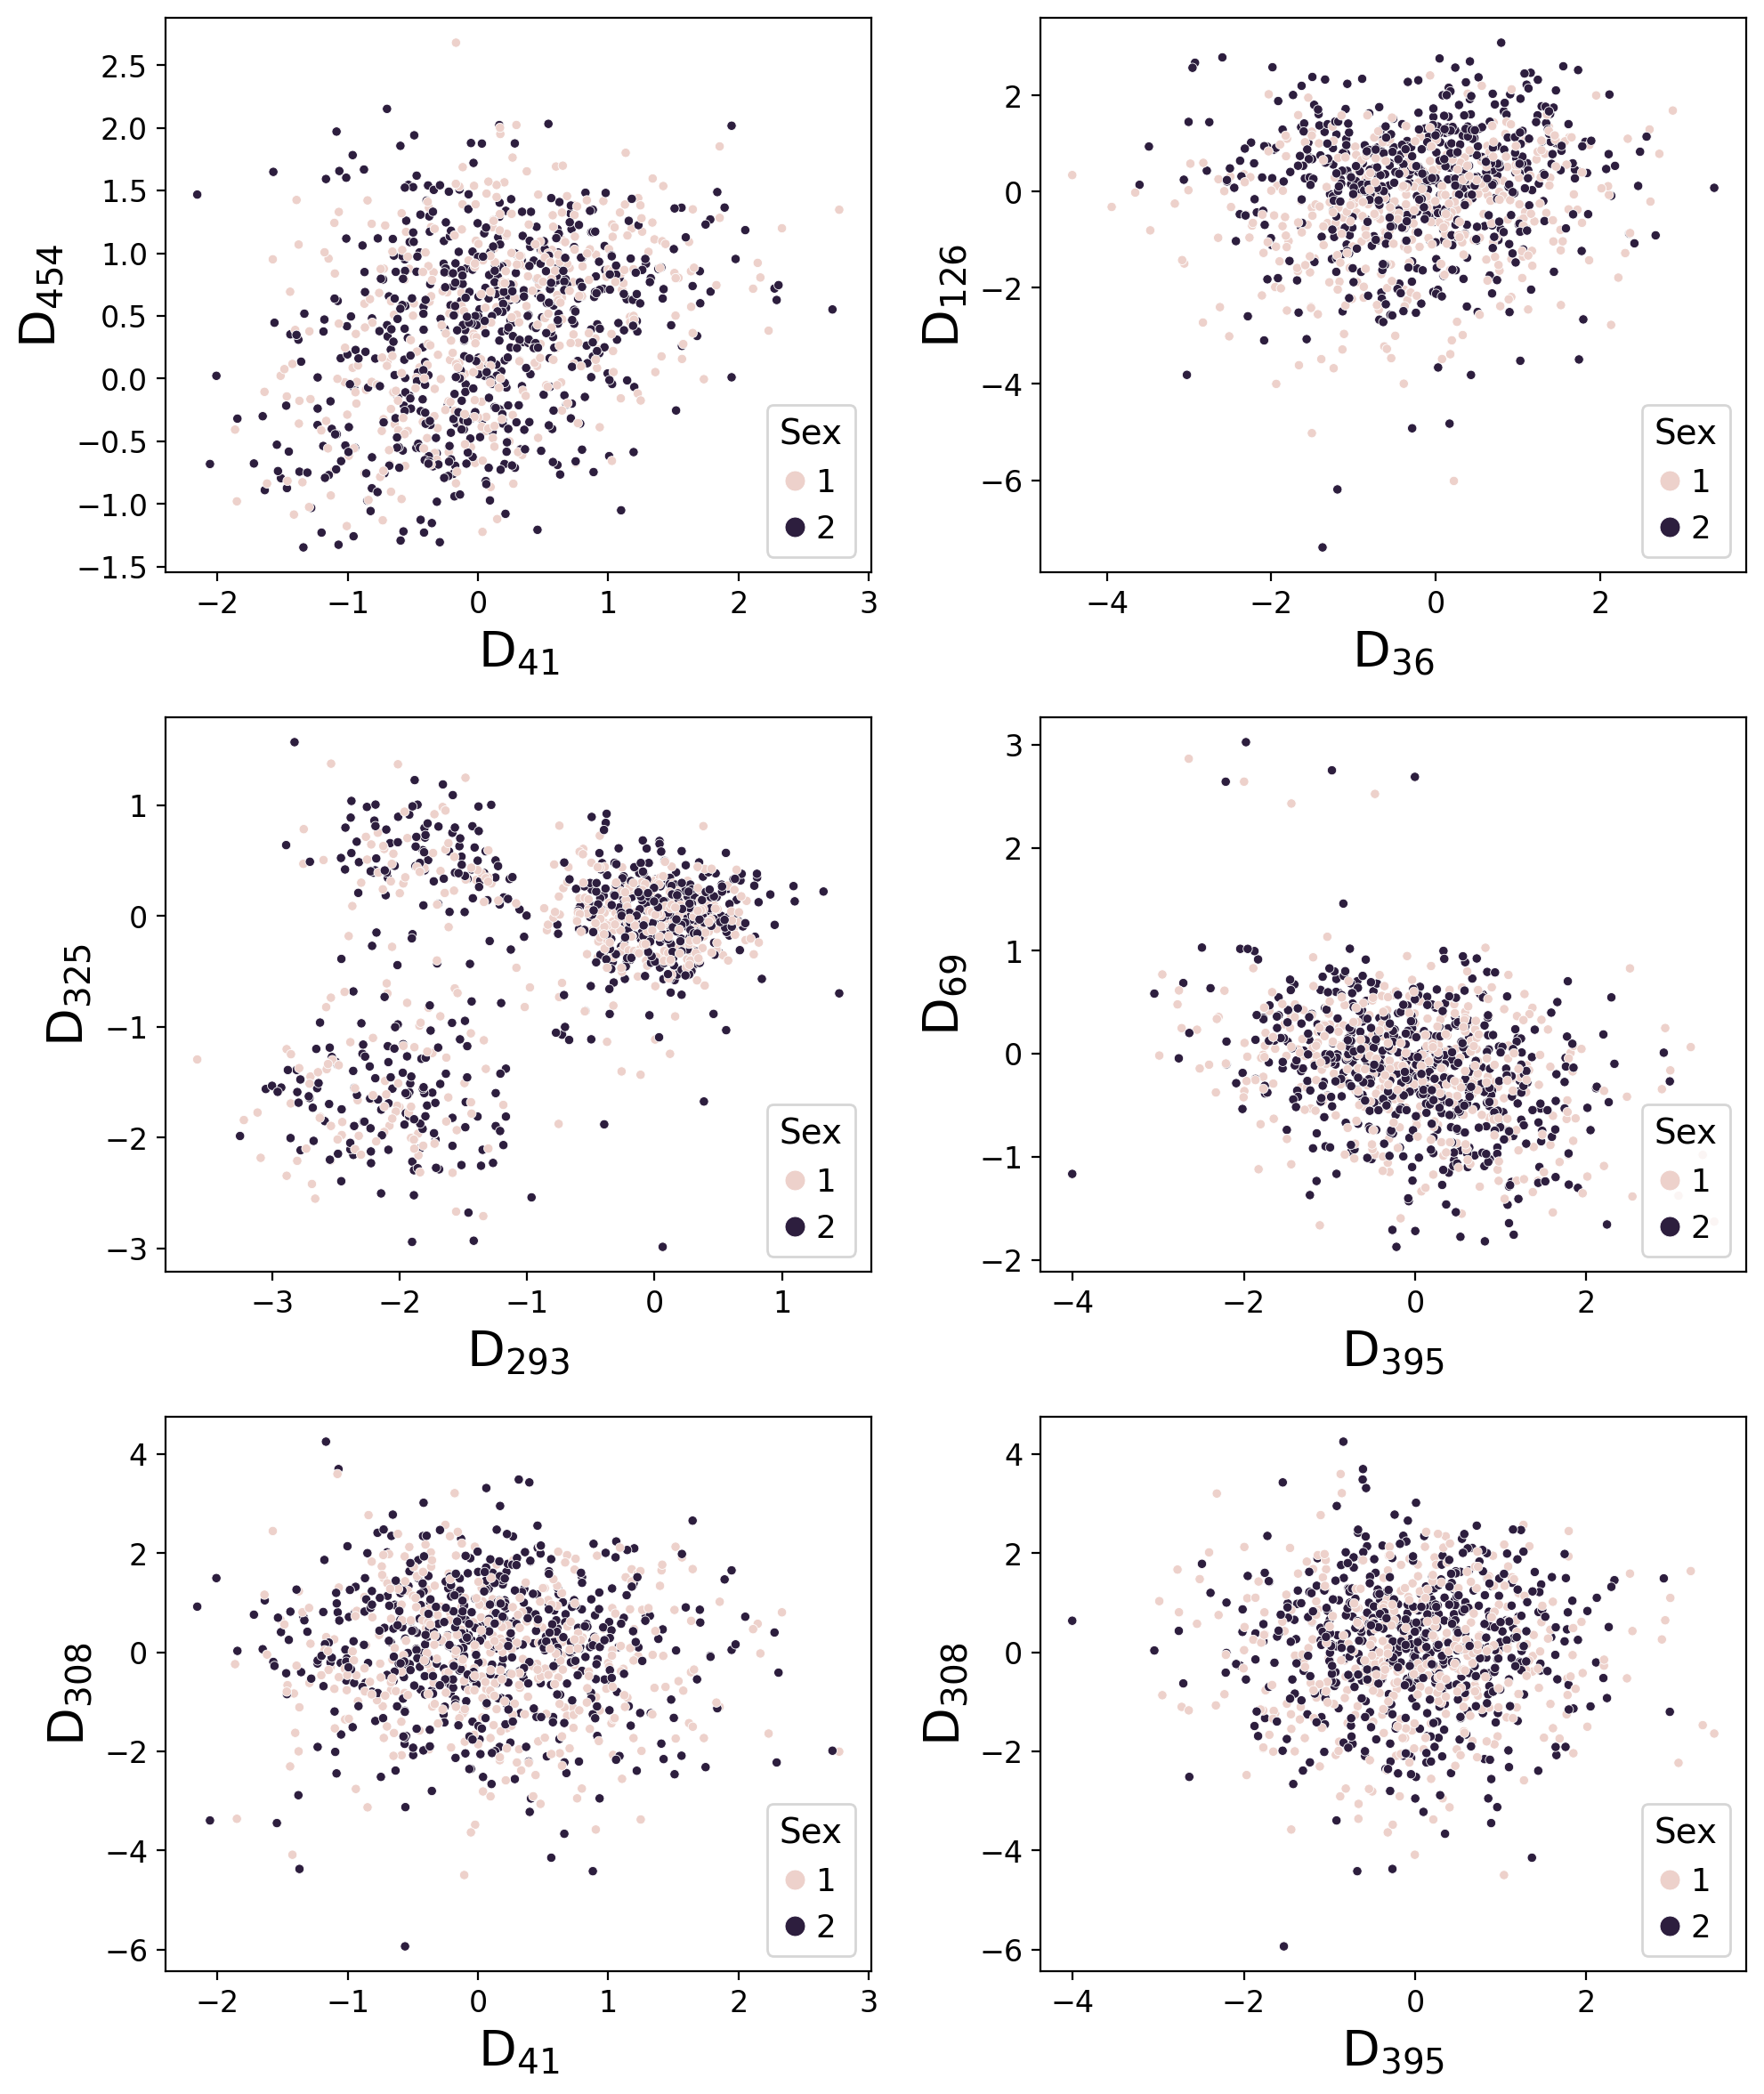

In [58]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,12), constrained_layout=False)
axs = axs.flatten()

sns.scatterplot(x="D_Factor41", y="D_Factor454", hue="sex", data=tmp, ax=axs[0], s=14)
axs[0].legend(title="Sex", markerscale=2.2, loc="lower right")
axs[0].set_xlabel("D$_{41}$")
axs[0].set_ylabel("D$_{454}$")


sns.scatterplot(x="D_Factor36", y="D_Factor126", hue="sex", data=tmp, ax=axs[1], s=14)
axs[1].legend(title="Sex", markerscale=2.2, loc="lower right")
axs[1].set_xlabel("D$_{36}$")
axs[1].set_ylabel("D$_{126}$")


sns.scatterplot(x="D_Factor293", y="D_Factor325", hue="sex", data=tmp, ax=axs[2], s=14)
axs[2].legend(title="Sex", markerscale=2.2, loc="lower right")
axs[2].set_xlabel("D$_{293}$")
axs[2].set_ylabel("D$_{325}$")


sns.scatterplot(x="D_Factor395", y="D_Factor69", hue="sex", data=tmp, ax=axs[3], s=14)
axs[3].legend(title="Sex", markerscale=2.2, loc="lower right")
axs[3].set_xlabel("D$_{395}$")
axs[3].set_ylabel("D$_{69}$")


sns.scatterplot(x="D_Factor41", y="D_Factor308", hue="sex", data=tmp, ax=axs[4], s=14)
axs[4].legend(title="Sex", markerscale=2.2, loc="lower right")
axs[4].set_xlabel("D$_{41}$")
axs[4].set_ylabel("D$_{308}$")


sns.scatterplot(x="D_Factor395", y="D_Factor308", hue="sex", data=tmp, ax=axs[5], s=14)
axs[5].legend(title="Sex", markerscale=2.2, loc="lower right")
axs[5].set_xlabel("D$_{395}$")
axs[5].set_ylabel("D$_{308}$")


for ax in axs:
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)
    ax.tick_params(labelsize=12)

# fig.delaxes(axs[-1])

plt.tight_layout()

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associated-factors-colored-by-sex.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_PRS-associated-factors-colored-by-sex.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")


### Scatterplot of PRS vs. factor

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


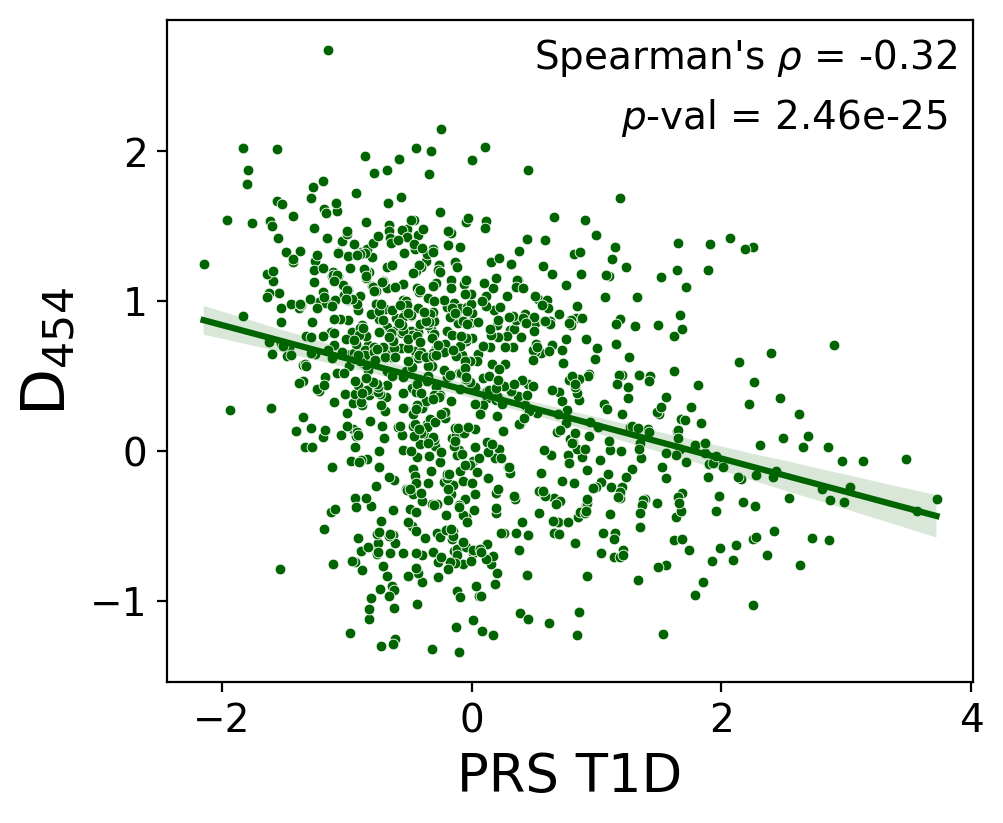

In [142]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(4.9,4), constrained_layout=True)

sns.scatterplot(x="T1D", y="D_Factor454", data=tmp, color=PRS_colors_dark["T1D"],
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="T1D", y="D_Factor454", data=tmp, color=PRS_colors_dark["T1D"], ax=axs, scatter=False)
axs.set_xlabel("PRS T1D", fontsize=19)
axs.set_ylabel("D$_{454}$", fontsize=22)
corr, pval = spearmanr(tmp["T1D"], tmp["D_Factor454"])
axs.text(x=0.5, y=2.55, s=fr"Spearman's $\rho$ = {np.round(corr,2)}",
            fontdict={"color":"black", "fontsize":14, "ma":"right"})
axs.text(x=1.2, y=2.15, s=f"$p$-val = {pval:.2e}",
           fontdict={"color":"black", "fontsize":14, "ma":"right"})

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-T1D_vs_D454_color.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-T1D_vs_D454_color.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-T1D_vs_D454_color.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


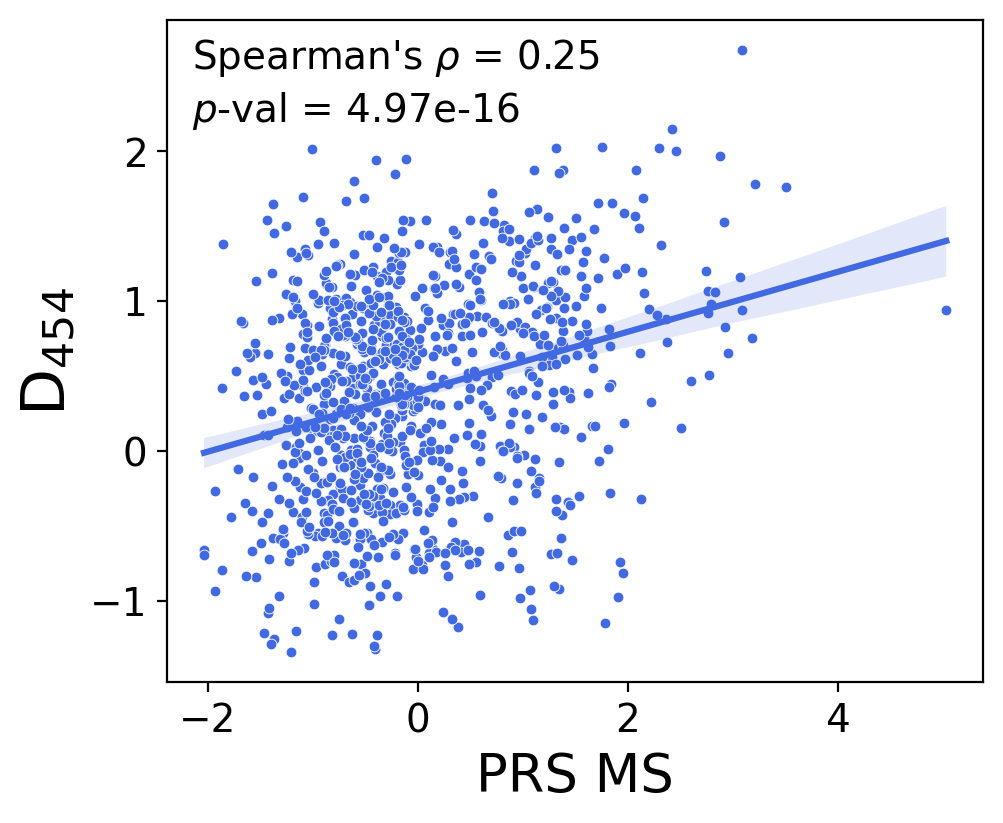

In [143]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(4.9,4), constrained_layout=True)

sns.scatterplot(x="Multiple_sclerosis", y="D_Factor454", data=tmp, color=PRS_colors_dark["MS"],
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="Multiple_sclerosis", y="D_Factor454", data=tmp, color=PRS_colors_dark["MS"], ax=axs, scatter=False)
axs.set_xlabel("PRS MS", fontsize=19)
axs.set_ylabel("D$_{454}$", fontsize=22)
corr, pval = spearmanr(tmp["Multiple_sclerosis"], tmp["D_Factor454"])
axs.text(x=-2.15, y=2.55, s=fr"Spearman's $\rho$ = {np.round(corr,2)}",
            fontdict={"color":"black", "fontsize":14, "ma":"right"})
axs.text(x=-2.15, y=2.2, s=f"$p$-val = {pval:.2e}",
           fontdict={"color":"black", "fontsize":14, "ma":"right"})

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-MS_vs_D454_color.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-MS_vs_D454_color.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-MS_vs_D454_color.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


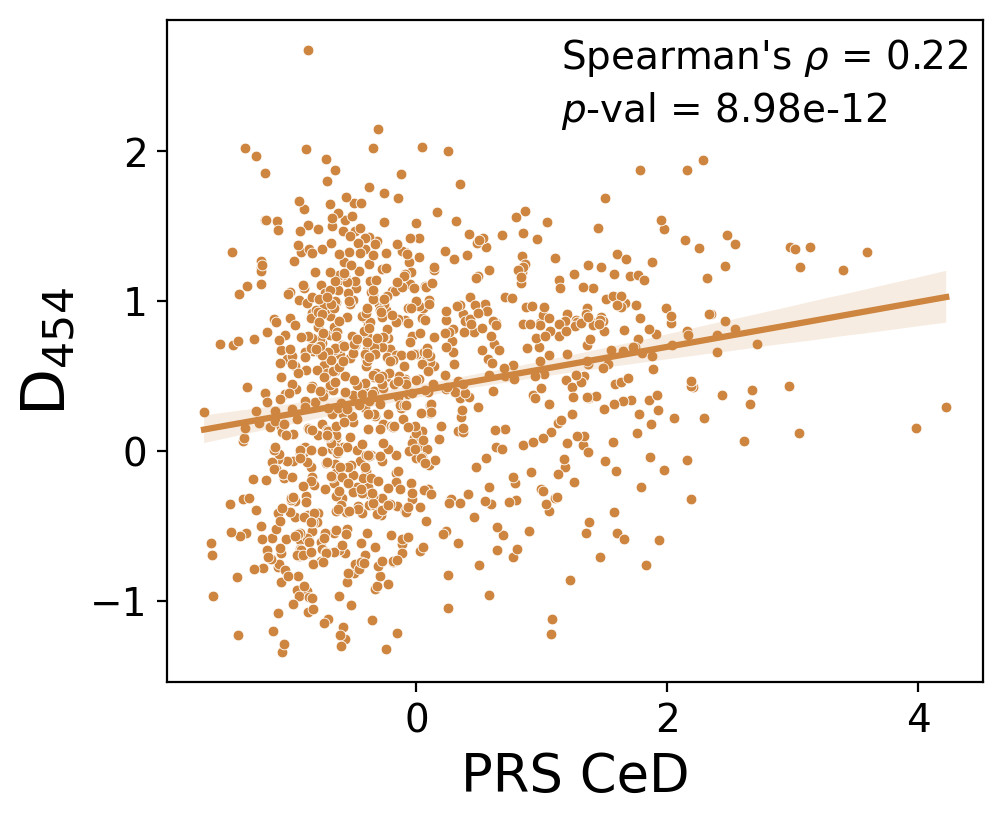

In [191]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(4.9,4), constrained_layout=True)

sns.scatterplot(x="Celiac", y="D_Factor454", data=tmp, color=PRS_colors_dark["CeD"],
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="Celiac", y="D_Factor454", data=tmp, color=PRS_colors_dark["CeD"], ax=axs, scatter=False)
axs.set_xlabel("PRS CeD", fontsize=19)
axs.set_ylabel("D$_{454}$", fontsize=22)
corr, pval = spearmanr(tmp["Celiac"], tmp["D_Factor454"])
axs.text(x=1.15, y=2.55, s=fr"Spearman's $\rho$ = {np.round(corr,2)}",
            fontdict={"color":"black", "fontsize":14, "ma":"right"})
axs.text(x=1.15, y=2.2, s=f"$p$-val = {pval:.2e}",
           fontdict={"color":"black", "fontsize":14, "ma":"right"})

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-CeD_vs_D454_color.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-CeD_vs_D454_color.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-CeD_vs_D454_color.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


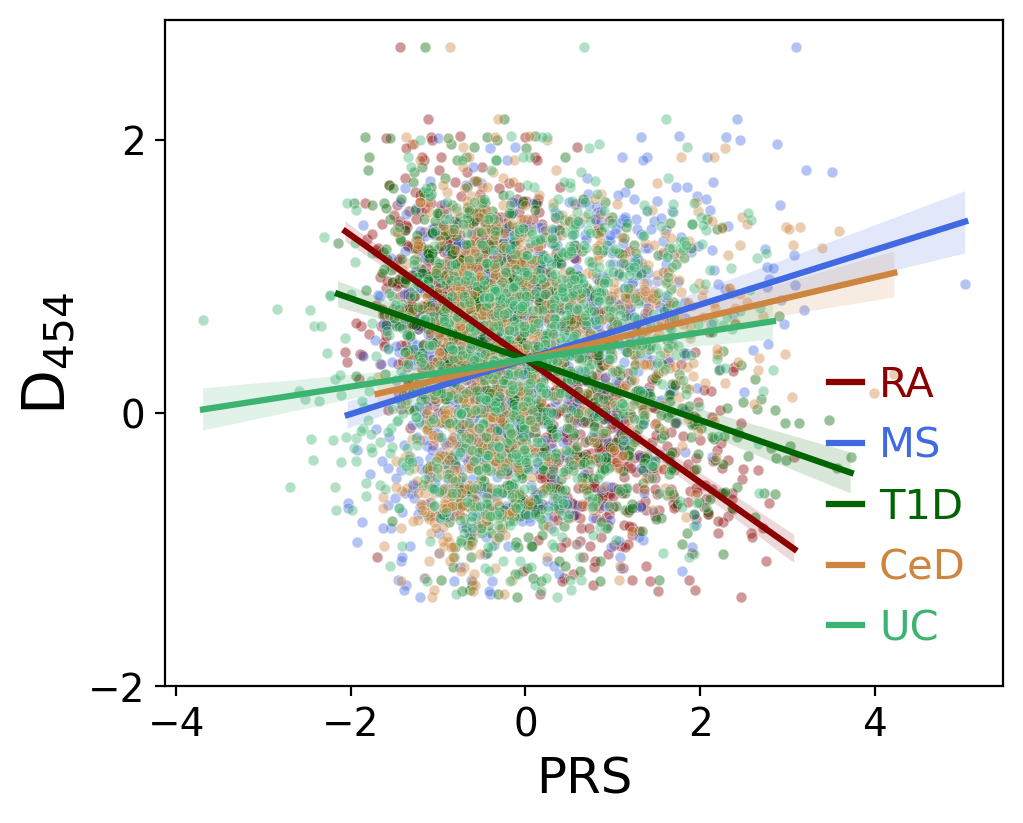

In [113]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5,4), constrained_layout=True)

sns.scatterplot(x="RA", y="D_Factor454", data=tmp, color=PRS_colors_dark["RA"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="RA", y="D_Factor454", data=tmp, color=PRS_colors_dark["RA"], ax=axs, scatter=False, label="RA")

sns.scatterplot(x="Multiple_sclerosis", y="D_Factor454", data=tmp, color=PRS_colors_dark["MS"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="Multiple_sclerosis", y="D_Factor454", data=tmp, color=PRS_colors_dark["MS"], ax=axs, scatter=False, label="MS")

sns.scatterplot(x="T1D", y="D_Factor454", data=tmp, color=PRS_colors_dark["T1D"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="T1D", y="D_Factor454", data=tmp, color=PRS_colors_dark["T1D"], ax=axs, scatter=False, label="T1D")

sns.scatterplot(x="Celiac", y="D_Factor454", data=tmp, color=PRS_colors_dark["CeD"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="Celiac", y="D_Factor454", data=tmp, color=PRS_colors_dark["CeD"], ax=axs, scatter=False, label="CeD")

sns.scatterplot(x="UC", y="D_Factor454", data=tmp, color=PRS_colors_dark["UC"], alpha=0.4,
                ax=axs, s=15, legend=False, rasterized=True)
sns.regplot(x="UC", y="D_Factor454", data=tmp, color=PRS_colors_dark["UC"], ax=axs, scatter=False, label="UC")

ymin = axs.get_yticks().min()
ymax = axs.get_yticks().max()
xmin = axs.get_xticks().min()
xmax = axs.get_xticks().max()

axs.set_ylabel("D$_{454}$", fontsize=21)
axs.set_yticks(
    np.arange(ymin, ymax, 2) 
    if 0 in np.arange(ymin, ymax, 2) 
    else np.arange(ymin+1, ymax, 2)
)
axs.set_xlabel("PRS", fontsize=18)
#axs.set_xticks(np.arange(xmin+2, xmax, 2))

# corr, pval = spearmanr(tmp["RA"], tmp["U_Factor454"])
# axs.text(x=0.73, y=2.3, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
#              fontdict={"color":PRS_colors_dark["RA"], "fontsize":12, "ma":"right"})

# corr, pval = spearmanr(tmp["MS"], tmp["U_Factor454"])
# axs.text(x=0.73, y=2.3, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
#              fontdict={"color":PRS_colors_dark["MS"], "fontsize":12, "ma":"right"})

# corr, pval = spearmanr(tmp["T1D"], tmp["U_Factor454"])
# axs.text(x=0.73, y=2.3, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
#              fontdict={"color":PRS_colors_dark["T1D"], "fontsize":12, "ma":"right"})

# corr, pval = spearmanr(tmp["Celiac"], tmp["U_Factor454"])
# axs.text(x=0.8, y=2.69, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
#              fontdict={"color":PRS_colors_dark["CeD"], "fontsize":12, "ma":"right"})

# corr, pval = spearmanr(tmp["UC"], tmp["U_Factor454"])
# axs.text(x=0.73, y=2.3, s=fr"$\rho$ = {np.round(corr,2)}; $p$-val = {pval:.2e}",
#              fontdict={"color":PRS_colors_dark["UC"], "fontsize":12, "ma":"right"})
# axs.text(x=1.8, y=2, s=f"$p$-val = {pval:.2e}",
#            fontdict={"color":"black", "fontsize":14, "ma":"right"})

axs.legend(frameon=False, handlelength=0.8, markerscale=30, fontsize=15,
           labelcolor=[PRS_colors_dark["RA"], PRS_colors_dark["MS"], PRS_colors_dark["T1D"], PRS_colors_dark["CeD"], PRS_colors_dark["UC"]])

plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-RA-and-MS-and-T1D-and-CeD-and-UC_vs_D454.png"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-RA-and-MS-and-T1D-and-CeD-and-UC_vs_D454.pdf"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Scatterplot_PRS-RA-and-MS-and-T1D-and-CeD-and-UC_vs_D454.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")

## Plot effect on cells

### RA

In [122]:
RA_EFFECT = calculate_DxC_effect(
    DxC_associations = PRS_effects,
    SNP_id = "RA",
    cell_state_latent = cell_state,
    A = assignment_matrix,
)
RA_EFFECT

DxC_Factor19  DxC_Factor41  DxC_Factor72  DxC_Factor210  \
barcode                                                                       
AAACCTGAGAATGTTG-1      0.008688     -0.009469     -0.016501       0.003045   
AAACCTGAGAGAACAG-1      0.004344     -0.019590     -0.144816       0.002388   
AAACCTGAGCATGGCA-1      0.016133     -0.029437     -0.013218       0.007551   
AAACCTGAGTATTGGA-1      0.005437     -0.031379     -0.048998       0.003840   
AAACCTGAGTGTCCCG-1      0.005089     -0.017873     -0.053903       0.003081   
...                          ...           ...           ...            ...   
TTTGTCATCCGCTGTT-9      0.042738     -0.096624     -0.016959       0.045416   
TTTGTCATCCGTTGTC-9      0.014256     -0.033545     -0.019150       0.012610   
TTTGTCATCGCCGTGA-9      0.008496     -0.021884     -0.024525       0.007635   
TTTGTCATCGCGGATC-9      0.006163     -0.012170     -0.012136       0.003155   
TTTGTCATCTCGTATT-9      0.005629     -0.016110     -0.019689       0.001669   

                    DxC_Factor293  DxC_Factor454  DxC_Factor484  \
barcode                                                           
AAACCTGAGAATGTTG-1       0.042808      -0.092857       0.026172   
AAACCTGAGAGAACAG-1       0.056571      -0.197980       0.038494   
AAACCTGAGCATGGCA-1       0.060962      -0.069529       0.035760   
AAACCTGAGTATTGGA-1       0.061362      -0.110755       0.033116   
AAACCTGAGTGTCCCG-1       0.097321      -0.095859       0.049210   
...                           ...            ...            ...   
TTTGTCATCCGCTGTT-9       0.155537      -0.072373       0.027282   
TTTGTCATCCGTTGTC-9       0.074815      -0.054385       0.030152   
TTTGTCATCGCCGTGA-9       0.051723      -0.055166       0.014658   
TTTGTCATCGCGGATC-9       0.023067      -0.069379       0.028403   
TTTGTCATCTCGTATT-9       0.048645      -0.107536       0.048396   

                    DxC_Factor634  DxC_Factor663  
barcode                                           
AAACCTGAGAATGTTG-1      -0.004238      -0.007137  
AAACCTGAGAGAACAG-1      -0.003324      -0.003844  
AAACCTGAGCATGGCA-1      -0.010511      -0.012272  
AAACCTGAGTATTGGA-1      -0.005345      -0.003687  
AAACCTGAGTGTCCCG-1      -0.004289      -0.004222  
...                           ...            ...  
TTTGTCATCCGCTGTT-9      -0.063220      -0.018441  
TTTGTCATCCGTTGTC-9      -0.017554      -0.007746  
TTTGTCATCGCCGTGA-9      -0.010628      -0.005078  
TTTGTCATCGCGGATC-9      -0.004392      -0.004871  
TTTGTCATCTCGTATT-9      -0.002323      -0.005170  

[1172790 rows x 9 columns]

In [123]:
RA_EFFECT_ct = RA_EFFECT.merge(adata.obs.cell_label, right_index=True, left_index=True)
RA_EFFECT_ct = RA_EFFECT_ct.groupby("cell_label", observed=False).apply(lambda x: x.mean(axis=0))
RA_EFFECT_ct

DxC_Factor19  DxC_Factor41  DxC_Factor72  DxC_Factor210  \
cell_label                                                            
B IN            0.048535     -0.108368     -0.023512       0.047844   
B Mem           0.046808     -0.098371     -0.017493       0.044096   
CD4 ET          0.010591     -0.023436     -0.019800       0.005081   
CD4 NC          0.010358     -0.022950     -0.019348       0.005519   
CD4 SOX4        0.011049     -0.027496     -0.022502       0.005373   
CD8 ET          0.009326     -0.021520     -0.068259       0.004475   
CD8 NC          0.010184     -0.024892     -0.020106       0.004639   
CD8 S100B       0.008991     -0.025601     -0.033001       0.003848   
DC              0.019134     -0.075649     -0.043039       0.012519   
Mono C          0.007109     -0.020007     -0.063646       0.004160   
Mono NC         0.008094     -0.012327     -0.060182       0.003571   
NK              0.010430     -0.021851     -0.156061       0.004621   
NK R            0.008988     -0.049129     -0.096806       0.006283   
Plasma          0.052185     -0.044984     -0.018102       0.019073   

            DxC_Factor293  DxC_Factor454  DxC_Factor484  DxC_Factor634  \
cell_label                                                               
B IN             0.173803      -0.077959       0.023584      -0.066599   
B Mem            0.174180      -0.069314       0.028790      -0.061382   
CD4 ET           0.050928      -0.079323       0.029804      -0.007073   
CD4 NC           0.052093      -0.074960       0.029453      -0.007682   
CD4 SOX4         0.050742      -0.080045       0.029285      -0.007480   
CD8 ET           0.094805      -0.133930       0.056195      -0.006229   
CD8 NC           0.057384      -0.084875       0.033021      -0.006457   
CD8 S100B        0.061719      -0.104821       0.032382      -0.005356   
DC               0.121864      -0.121262       0.019816      -0.017426   
Mono C           0.121481      -0.163770       0.020739      -0.005791   
Mono NC          0.113017      -0.148670       0.065820      -0.004970   
NK               0.057166      -0.212655       0.029033      -0.006432   
NK R             0.052920      -0.149600       0.016849      -0.008746   
Plasma           0.141884      -0.159747       0.027439      -0.026550   

            DxC_Factor663  
cell_label                 
B IN            -0.022992  
B Mem           -0.023342  
CD4 ET          -0.008241  
CD4 NC          -0.007837  
CD4 SOX4        -0.008605  
CD8 ET          -0.007363  
CD8 NC          -0.008085  
CD8 S100B       -0.007277  
DC              -0.015813  
Mono C          -0.011899  
Mono NC         -0.012954  
NK              -0.008423  
NK R            -0.006008  
Plasma          -0.041676

#### DxC454

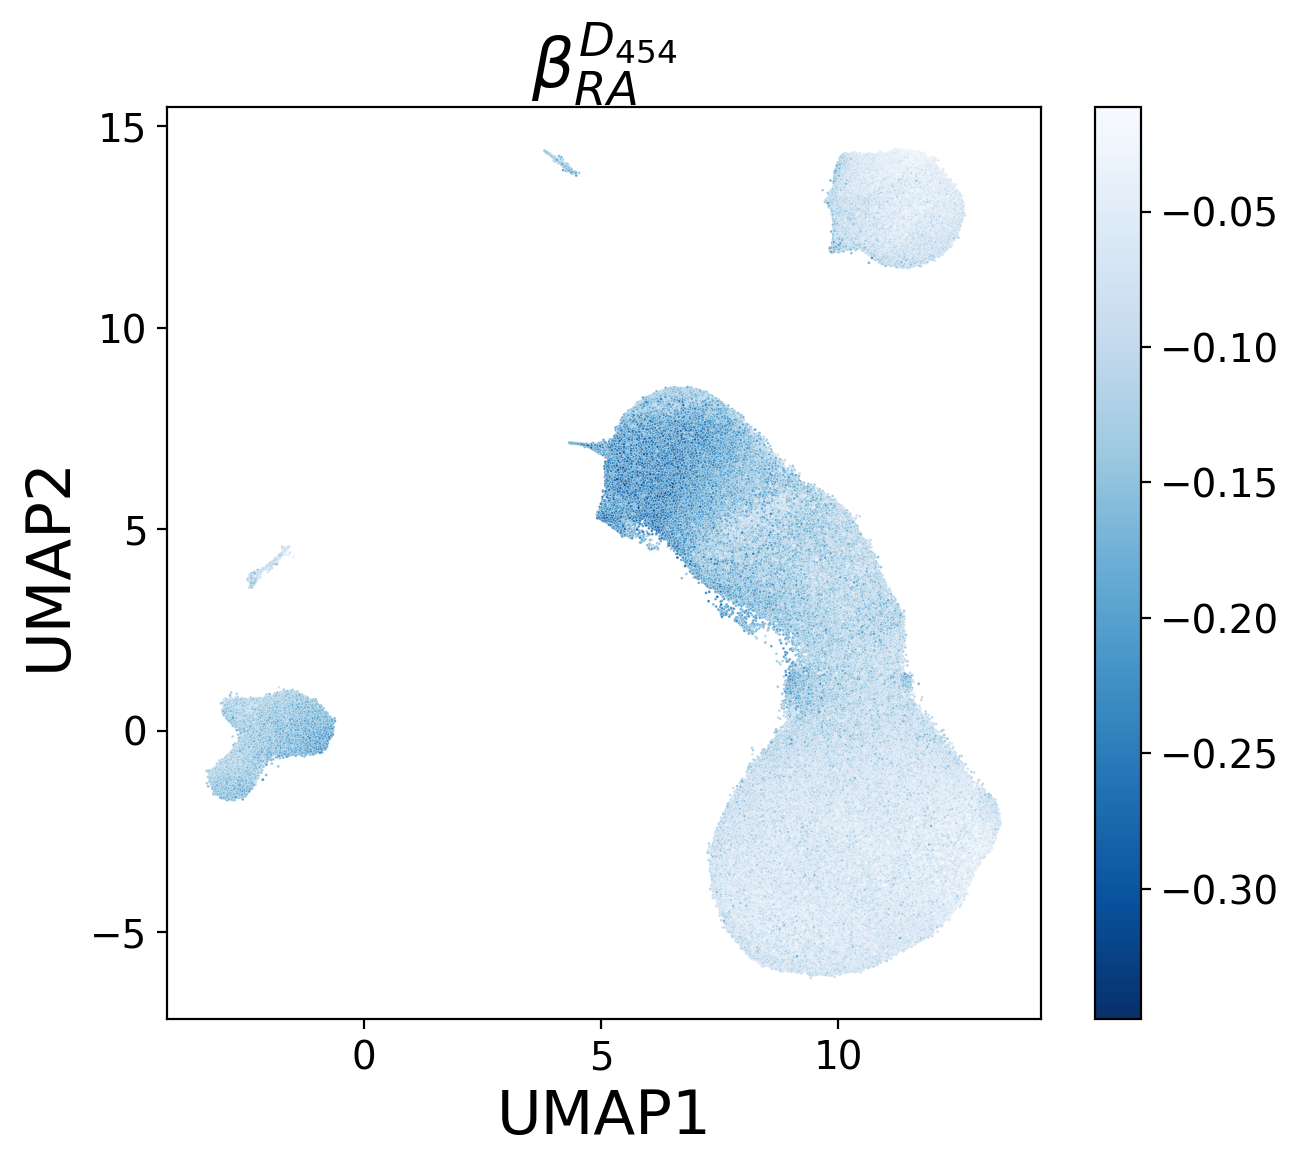

In [138]:
fig, axs = plt.subplots(figsize=(7,6))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="DxC_Factor454",
    data=umap_cc.merge(RA_EFFECT, right_index=True, left_index=True),
    ax=axs,
    s=1,
    palette="Blues_r",
    hue_norm=(RA_EFFECT["DxC_Factor454"].min(), RA_EFFECT["DxC_Factor454"].max()),
    rasterized=True,
    legend=False,
)

sm = cm.ScalarMappable(
    cmap="Blues_r",
    norm=colors.Normalize(
        vmin=RA_EFFECT["DxC_Factor454"].min(),
        vmax=RA_EFFECT["DxC_Factor454"].max(),
    ),
)
cb = plt.colorbar(sm, ax=axs)

axs.set_title(
    label=r"$\beta^{D_{454}}_{RA}$", fontdict={"fontsize": 24}, loc="center"
)
axs.xaxis.label.set_fontsize(22)
axs.yaxis.label.set_fontsize(22)

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_RA-effect-on-cells_D454.png"),
                         dpi=500, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_RA-effect-on-cells_D454.eps"),
                         dpi=500, transparent=True, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_RA-effect-on-cells_D454.pdf"),
                         dpi=500, transparent=True, bbox_inches="tight")

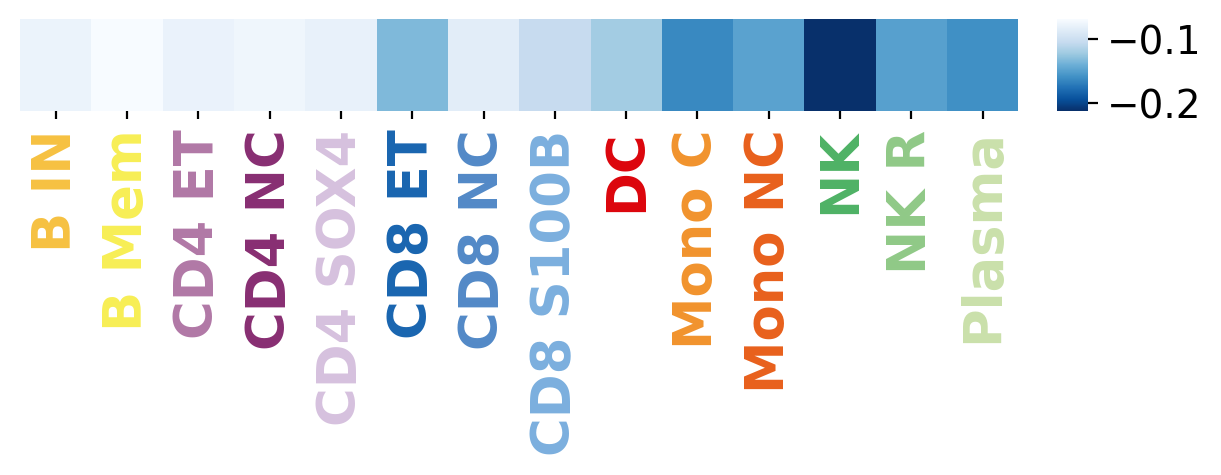

In [131]:
fig, axs = plt.subplots(figsize=(8,0.6))

sns.heatmap(RA_EFFECT_ct["DxC_Factor454"].to_frame().T, cmap="Blues_r", ax=axs, yticklabels=[], 
            cbar_kws={"anchor":(-0.15,0.5), "aspect":3})
axs.set_xlabel("")
axs.xaxis.label.set_fontsize(23)
axs.tick_params(axis="x", length=3)
for j, label in enumerate(axs.get_xticklabels()):
    label.set_color(cell_label_colors[label.get_text()])
    label.set_fontweight("bold")
    label.set_fontsize(19)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC454_effect_RA_celltype_heatmap.pdf"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC454_effect_RA_celltype_heatmap.png"), 
            bbox_inches="tight", transparent=True, dpi=600)
plt.savefig(os.path.join(model_results_dir, "Figures", "DxC454_effect_RA_celltype_heatmap.eps"), 
            bbox_inches="tight", transparent=True, dpi=600)


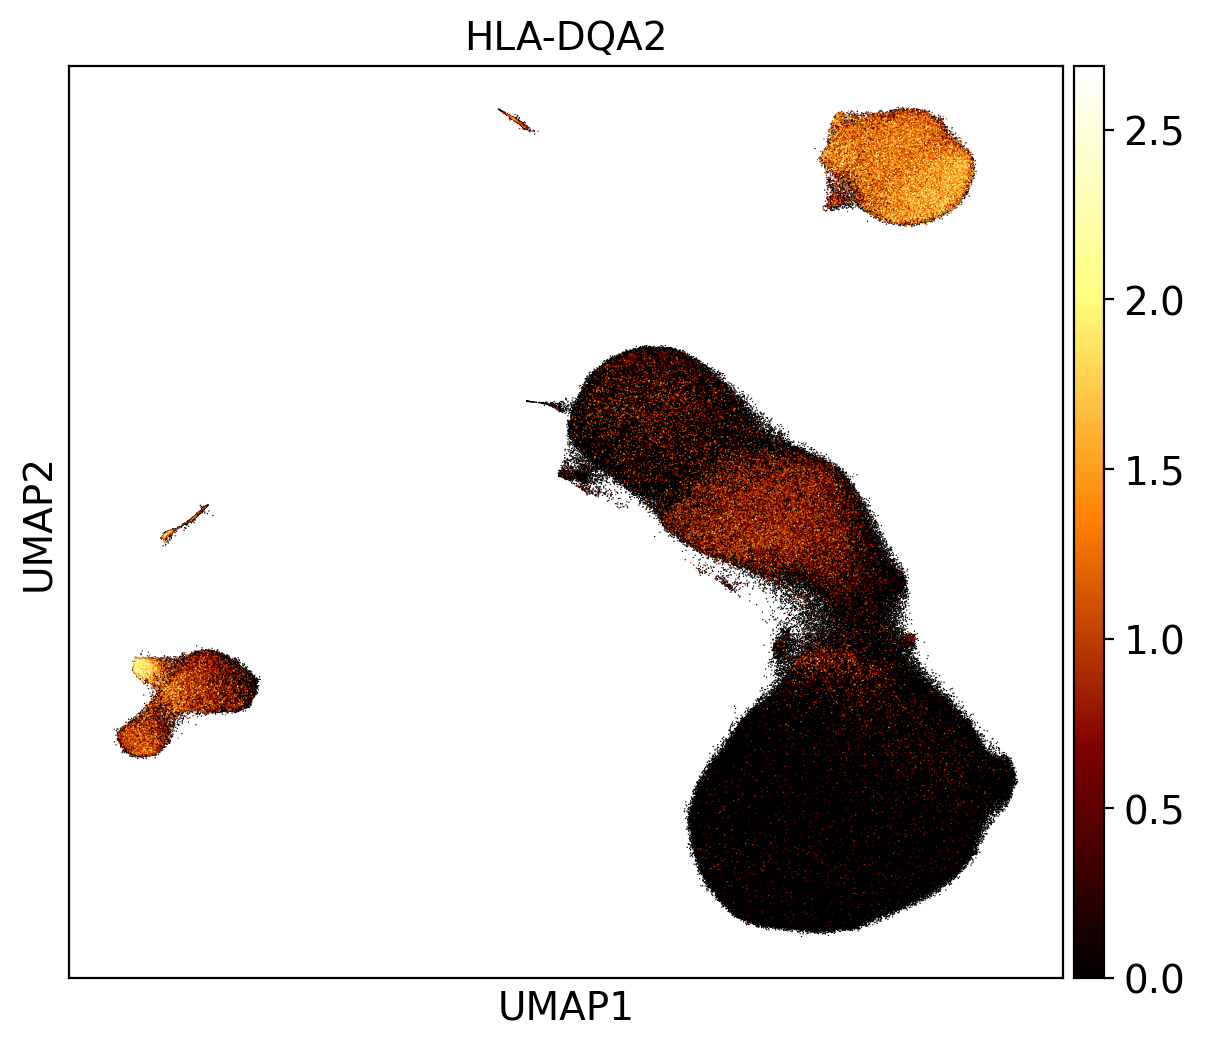

In [1028]:
sc.pl.umap(adata, color=adata.var.loc[adata.var.GeneSymbol == "HLA-DQA2"].index, title="HLA-DQA2", cmap="afmhot", size=1, hspace=0.14, save="_HLA-DQA2-expression.png")

## Assign effects to celltypes

In [155]:
D_celltype = assign_D_to_celltype(
    cell_state_latent=cell_state,
    A=assignment_matrix,
    cell_metadata=adata.obs,
    celltype_column="cell_label",
    top_one=True,
    assignment_threshold=0.9
)
D_celltype

{'D_Factor1': 'Mono NC',
 'D_Factor2': 'CD4 SOX4',
 'D_Factor3': None,
 'D_Factor4': 'CD4 SOX4',
 'D_Factor5': None,
 'D_Factor6': 'Mono NC',
 'D_Factor7': 'DC',
 'D_Factor8': 'Mono NC',
 'D_Factor9': None,
 'D_Factor10': None,
 'D_Factor11': 'CD8 S100B',
 'D_Factor12': 'Plasma',
 'D_Factor13': 'Mono NC',
 'D_Factor14': 'B IN',
 'D_Factor15': 'CD4 SOX4',
 'D_Factor16': 'Plasma',
 'D_Factor17': 'Plasma',
 'D_Factor18': 'Mono NC',
 'D_Factor19': 'Plasma',
 'D_Factor20': 'Mono NC',
 'D_Factor21': None,
 'D_Factor22': 'Mono NC',
 'D_Factor23': 'NK',
 'D_Factor24': 'Mono C',
 'D_Factor25': 'NK',
 'D_Factor26': 'CD4 ET',
 'D_Factor27': 'Mono C',
 'D_Factor28': 'NK',
 'D_Factor29': 'Plasma',
 'D_Factor30': 'Plasma',
 'D_Factor31': 'B IN',
 'D_Factor32': 'CD8 S100B',
 'D_Factor33': None,
 'D_Factor34': None,
 'D_Factor35': 'Mono NC',
 'D_Factor36': 'CD8 ET',
 'D_Factor37': None,
 'D_Factor38': None,
 'D_Factor39': 'CD4 SOX4',
 'D_Factor40': 'Plasma',
 'D_Factor41': 'B IN',
 'D_Factor42': 'CD4 

In [156]:
PRS_effects = PRS_effects.assign(Celltype = PRS_effects.apply(lambda x: D_celltype[x.Factor], axis=1))
PRS_effects = PRS_effects.explode("Celltype")
PRS_effects.head()

Factor     SNP_id  effect_size  effect_size_se       p_value  \
0  D_Factor19        CeD    -0.163174        0.024693  2.334779e-11   
1  D_Factor19         RA     0.124845        0.023360  7.291072e-08   
2  D_Factor36  Psoriasis     0.232348        0.038465  1.075110e-09   
3  D_Factor41        CeD     0.190772        0.026913  6.878921e-13   
4  D_Factor41         RA    -0.273531        0.025460  1.545146e-28   

   corrected_pvalue                   fPRS Celltype  
0      1.892400e-08        CeD__D_Factor19   Plasma  
1      4.010090e-05         RA__D_Factor19   Plasma  
2      7.198563e-07  Psoriasis__D_Factor36   CD8 ET  
3      6.620961e-10        CeD__D_Factor41     B IN  
4      4.759051e-25         RA__D_Factor41     B IN

## GSEA

### Find top genes for PRS-associated factors

In [159]:
prs_gene_ct = []
# Focus on autoimmune diseases
for prs in PRS_effects.loc[PRS_effects.SNP_id.isin(["IBD", "CeD", "UC", "T1D", "MS", "Psoriasis", "RA"])].SNP_id.unique():
    prs_topgene = []
    prs_ct = []
    prs_factor = []
    for idx, row in PRS_effects.loc[PRS_effects.SNP_id == prs].iterrows():
        topgenes = select_important_genes_for_factor_IQR(
            genes_factors_loadings=DxC_decoder.to_numpy(),
            factor_idx=int(row.Factor.replace("D_Factor", ""))-1,
            gene_names=adata.var.loc[DxC_decoder.index].GeneSymbol,
            direction="both",
            threshold = 100,
            plot = False,
        )
        prs_topgene.append(topgenes)
        prs_ct.append(row.Celltype)
        prs_factor.append(row.Factor)
    gene_ct = pd.DataFrame({"PRS": [prs]*len(prs_ct),
                            "Factor": prs_factor,
                            "TopGene": prs_topgene,
                            "Cell type": prs_ct})
    prs_gene_ct.append(gene_ct)

prs_gene_ct = pd.concat(prs_gene_ct, axis=0, ignore_index=True)
prs_gene_ct


/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


PRS       Factor                                  TopGene Cell type
0   CeD   D_Factor19     [RPL10, HLA-DPA1, HLA-DRA, HLA-DPB1]    Plasma
1   CeD   D_Factor41        [HLA-DRB1, HLA-DQA1, CD74, RPL14]      B IN
2   CeD   D_Factor69                               [HLA-DQB1]        NK
3   CeD   D_Factor72                               [HLA-DQA1]        NK
4   CeD  D_Factor210  [RPL13, RPL18A, RPS19, HLA-DQA1, RPL35]      B IN
..  ...          ...                                      ...       ...
56   MS  D_Factor663                               [HLA-DRB1]    Plasma
57   MS  D_Factor682                     [HLA-DQA2, HLA-DQB1]    Mono C
58   MS  D_Factor687       [HLA-DQA1, HLA-DQB1, RPL10, RPLP1]    Mono C
59   UC  D_Factor293                     [HLA-DQA2, HLA-DRB5]     B Mem
60   UC  D_Factor454                               [HLA-DQA2]        NK

[61 rows x 4 columns]

In [173]:
prs_gene_ct = prs_gene_ct.explode("TopGene")
prs_gene_ct

PRS       Factor   TopGene Cell type
0   CeD   D_Factor19     RPL10    Plasma
0   CeD   D_Factor19  HLA-DPA1    Plasma
0   CeD   D_Factor19   HLA-DRA    Plasma
0   CeD   D_Factor19  HLA-DPB1    Plasma
1   CeD   D_Factor41  HLA-DRB1      B IN
..  ...          ...       ...       ...
58   MS  D_Factor687     RPL10    Mono C
58   MS  D_Factor687     RPLP1    Mono C
59   UC  D_Factor293  HLA-DQA2     B Mem
59   UC  D_Factor293  HLA-DRB5     B Mem
60   UC  D_Factor454  HLA-DQA2        NK

[168 rows x 4 columns]

In [174]:
prs_gene_ct.TopGene.nunique()

55

In [175]:
prs_gene_ct.TopGene.unique()

array(['RPL10', 'HLA-DPA1', 'HLA-DRA', 'HLA-DPB1', 'HLA-DRB1', 'HLA-DQA1',
       'CD74', 'RPL14', 'HLA-DQB1', 'RPL13', 'RPL18A', 'RPS19', 'RPL35',
       'HLA-B', 'HLA-C', 'HLA-A', 'B2M', 'HLA-DRB5', 'CD52', 'PSMB9',
       'RARRES3', 'PSME2', 'WARS', 'VAMP5', 'RPS29', 'CD79A', 'HLA-DQA2',
       'GZMK', 'ZFP36', 'ACTB', 'CYBA', 'SEC61B', 'SUB1', 'BTN3A2',
       'RPLP1', 'DUSP2', 'TCF4', 'JUN', 'YBX3', 'RPLP0', 'BTG1', 'ARPC3',
       'AIF1', 'CD37', 'FTL', 'TMSB4X', 'RPL38', 'CCL3', 'CCL5', 'UBB',
       'KLRC1', 'MT-CO2', 'IGJ', 'MT-ND4', 'MT-CO1'], dtype=object)

In [176]:
prs_gene_ct.loc[
prs_gene_ct.PRS.isin(['CeD', 'RA', 'Psoriasis', 'T1D', 'MS', 'UC'])
].groupby("TopGene").apply(lambda x: x.PRS.unique())

/tmp/ipykernel_1261514/219590940.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


TopGene
ACTB                                    [CeD]
AIF1                              [Psoriasis]
ARPC3                             [Psoriasis]
B2M                                 [CeD, MS]
BTG1                                     [RA]
BTN3A2                                  [CeD]
CCL3                              [Psoriasis]
CCL5                              [Psoriasis]
CD37                              [Psoriasis]
CD52                                    [CeD]
CD74                                [CeD, RA]
CD79A                      [CeD, RA, T1D, MS]
CYBA                         [CeD, Psoriasis]
DUSP2                                    [RA]
FTL                               [Psoriasis]
GZMK                            [CeD, RA, MS]
HLA-A                               [CeD, MS]
HLA-B                    [CeD, Psoriasis, MS]
HLA-C                    [CeD, Psoriasis, MS]
HLA-DPA1                            [CeD, RA]
HLA-DPB1                   [CeD, RA, T1D, MS]
HLA-DQA1                  

/tmp/ipykernel_1261514/202891192.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Text(0.5, 1.0, '$N$ PRS associated with a given gene')

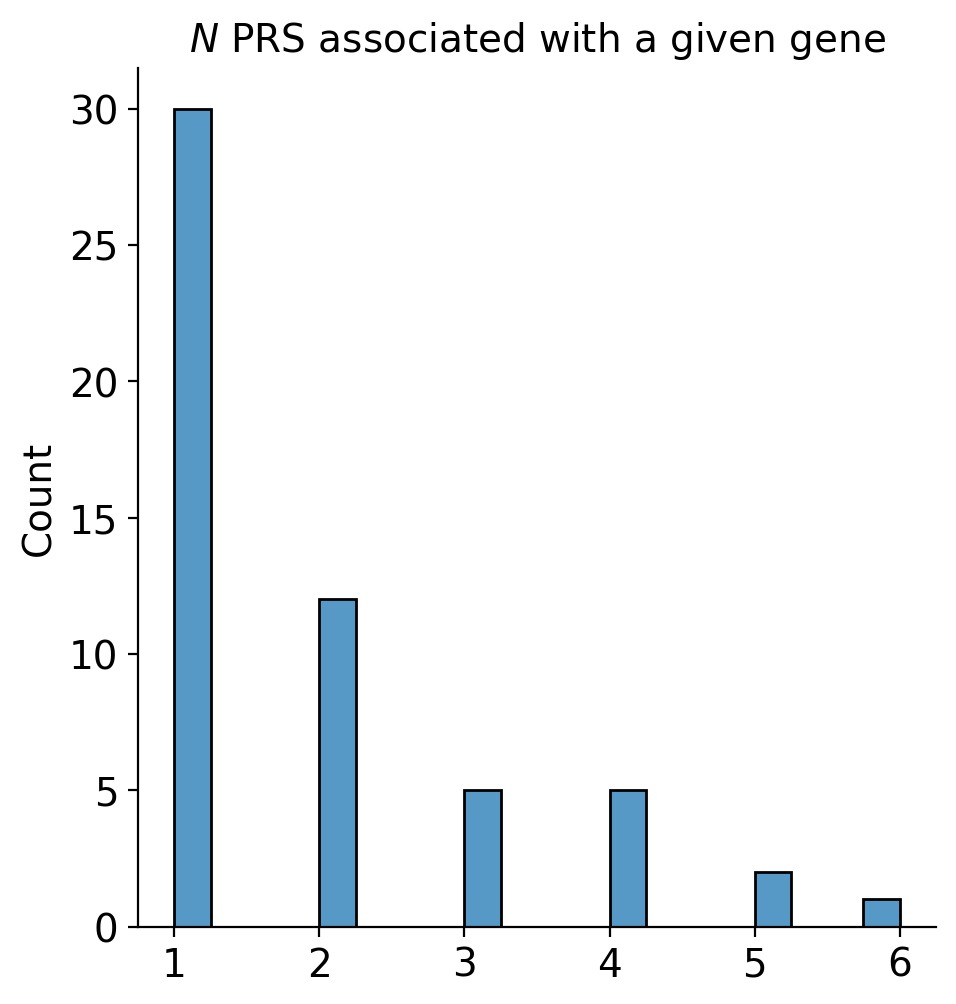

In [177]:
# N PRS associated with a given gene
sns.displot(prs_gene_ct.groupby("TopGene").apply(lambda x: x.PRS.nunique()).values, bins=20)
plt.title("$N$ PRS associated with a given gene")

In [178]:
# Check which genes are associated with more than 2 diseases
prs_gene_ct.groupby("TopGene").apply(lambda x: x.PRS.nunique()).loc[prs_gene_ct.groupby("TopGene").apply(lambda x: x.PRS.nunique()) > 2]

/tmp/ipykernel_1261514/4206438426.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_1261514/4206438426.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


TopGene
CD79A       4
GZMK        3
HLA-B       3
HLA-C       3
HLA-DPB1    4
HLA-DQA1    4
HLA-DQA2    5
HLA-DQB1    3
HLA-DRB1    5
HLA-DRB5    6
RPL10       4
RPLP1       4
RPS29       3
dtype: int64

In [179]:
prs_gene_ct.loc[prs_gene_ct.PRS == "RA"].groupby("Factor", observed=True).apply(lambda x: x.TopGene.unique())

/tmp/ipykernel_1261514/2498484252.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Factor
D_Factor19                  [RPL10, HLA-DPA1, HLA-DRA, HLA-DPB1]
D_Factor210              [RPL13, RPL18A, RPS19, HLA-DQA1, RPL35]
D_Factor293                                 [HLA-DQA2, HLA-DRB5]
D_Factor41                     [HLA-DRB1, HLA-DQA1, CD74, RPL14]
D_Factor454                                           [HLA-DQA2]
D_Factor484                           [HLA-DQA1, HLA-DRB5, GZMK]
D_Factor634    [DUSP2, HLA-DQA1, TCF4, JUN, YBX3, RPLP1, CD79...
D_Factor663                                           [HLA-DRB1]
D_Factor72                                            [HLA-DQA1]
dtype: object

In [182]:
adata.var.loc[DxC_decoder["DxC_Factor454"].sort_values().head(10).index].GeneSymbol

Geneid
ENSG00000237541    HLA-DQA2
ENSG00000204482        LST1
ENSG00000197746        PSAP
ENSG00000019582        CD74
ENSG00000172543        CTSW
ENSG00000162434        JAK1
ENSG00000163191     S100A11
ENSG00000197956      S100A6
ENSG00000197747     S100A10
ENSG00000181036       FCRL6
Name: GeneSymbol, dtype: object

In [183]:
prs_gene_ct.loc[prs_gene_ct.Factor == "D_Factor454"].TopGene.unique()

array(['HLA-DQA2'], dtype=object)

In [184]:
PRS_effects.loc[PRS_effects.Factor == "D_Factor454"].SNP_id.unique()

array(['CeD', 'RA', 'T1D', 'UC', 'MS'], dtype=object)

#### DxC41

In [1894]:
adata.var.loc[DxC_decoder["DxC_Factor41"].sort_values(ascending=False).head(10).index].GeneSymbol

Geneid
ENSG00000196735    HLA-DQA1
ENSG00000196126    HLA-DRB1
ENSG00000188846       RPL14
ENSG00000019582        CD74
ENSG00000115268       RPS15
ENSG00000130255       RPL36
ENSG00000164587       RPS14
ENSG00000105369       CD79A
ENSG00000142676       RPL11
ENSG00000122862        SRGN
Name: GeneSymbol, dtype: category
Categories (14194, object): ['A1BG', 'A1CF', 'A2M', 'A2ML1', ..., 'ZZEF1', 'ZZZ3', 'hsa-mir-150', 'hsa-mir-1199']

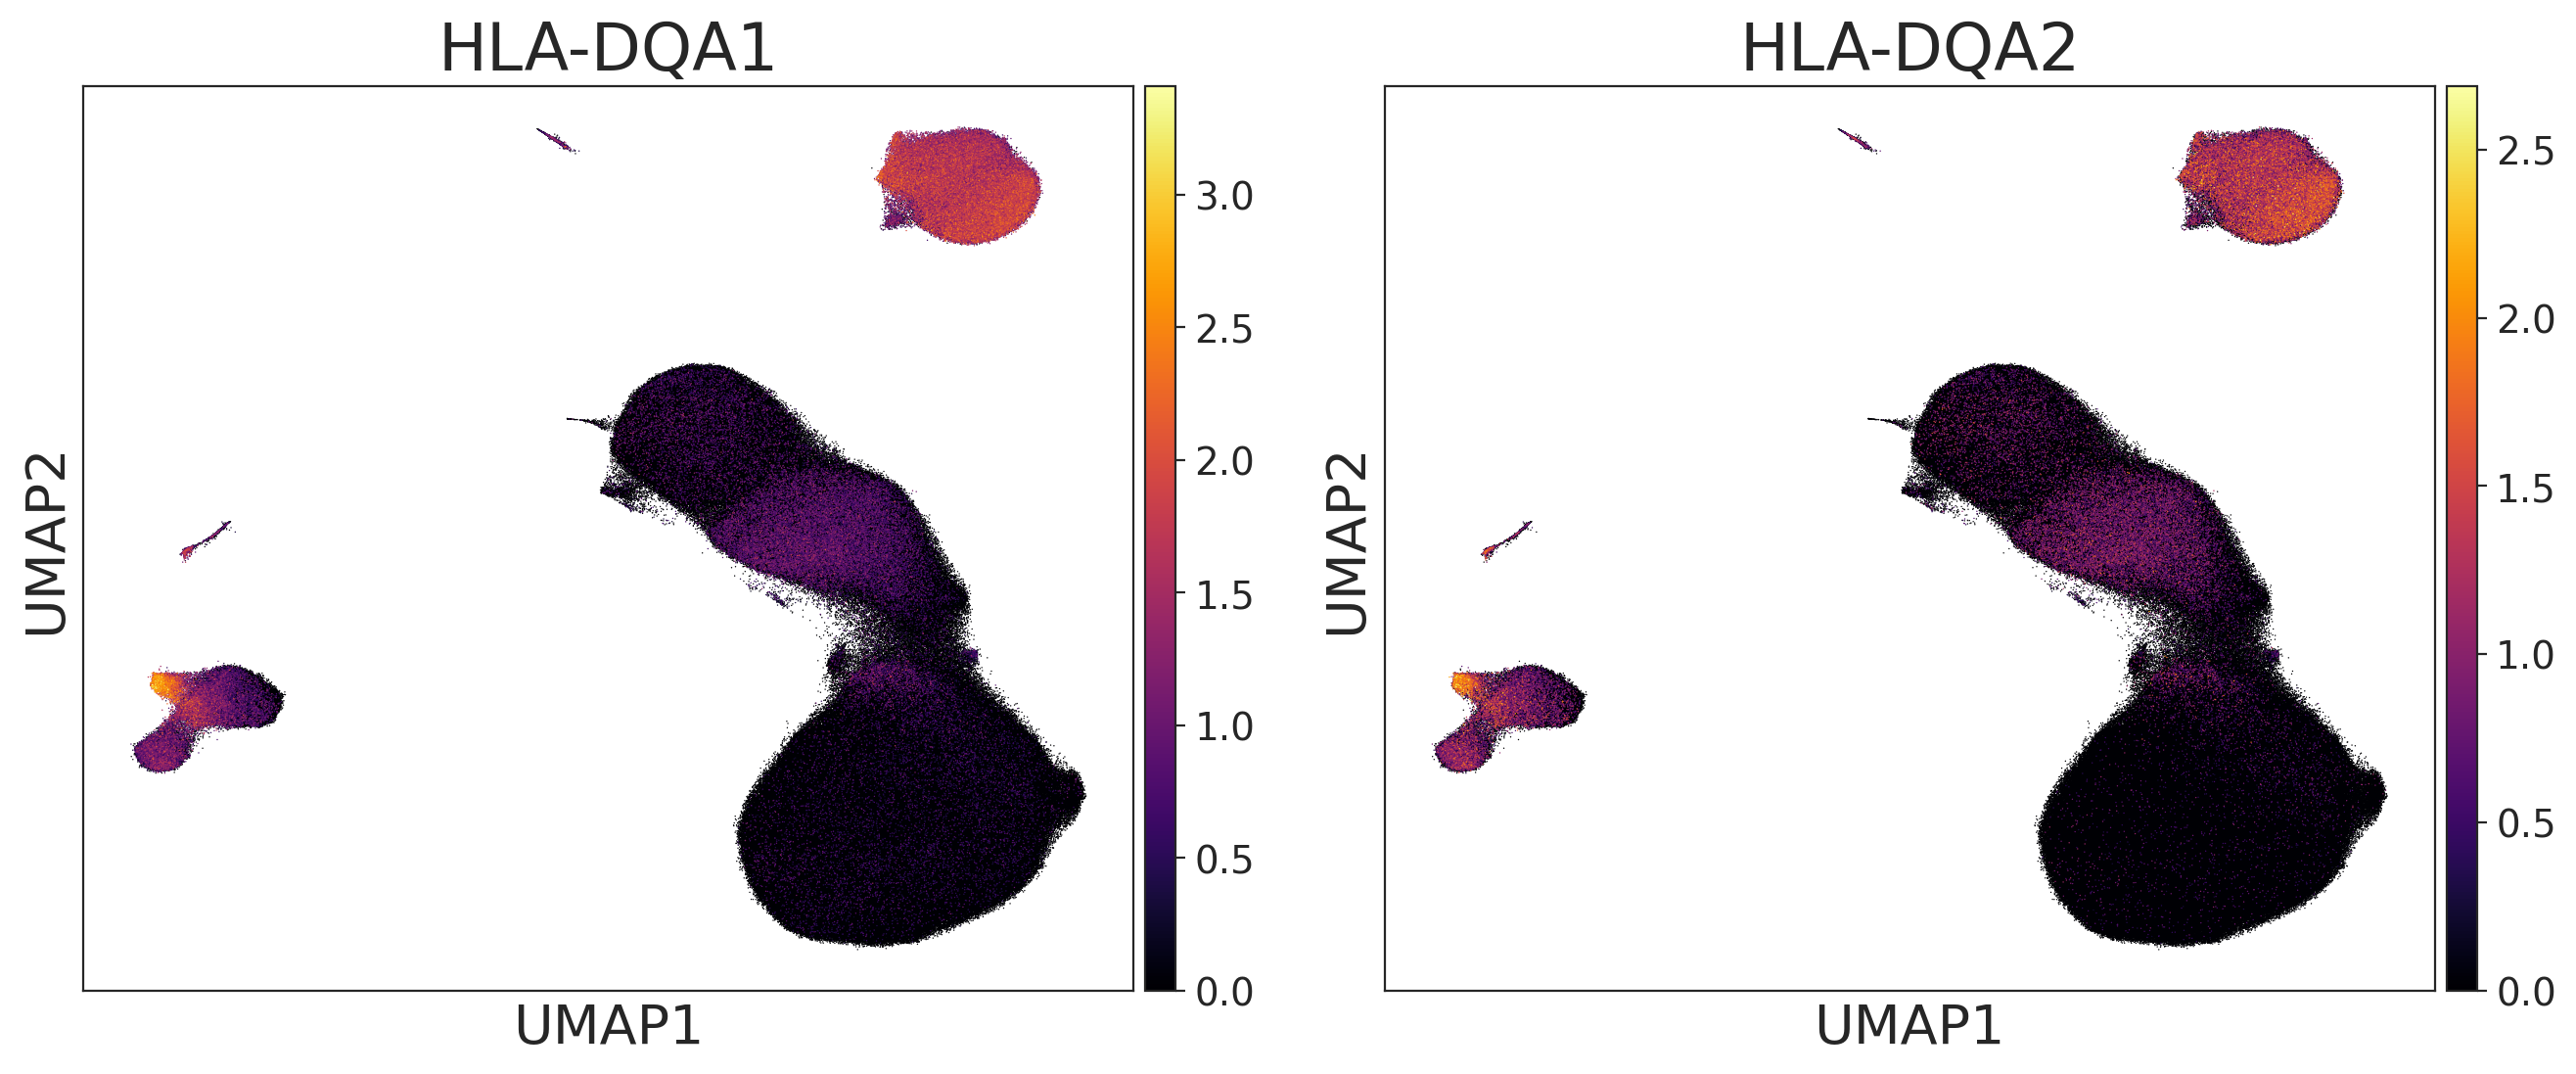

In [1470]:
# HLA-DQA1 vs HLA-DQA2 expression
axs = sc.pl.umap(adata,
                 color=adata.var.loc[adata.var.GeneSymbol.isin(["HLA-DQA1", "HLA-DQA2"])].index, 
                 title=adata.var.loc[adata.var.GeneSymbol.isin(["HLA-DQA1", "HLA-DQA2"])].GeneSymbol, 
                 cmap="inferno",
                 size=1,
                 hspace=0.14,
                 save=None,
                 show=False)

for ax in axs:
    ax.set_xlabel("UMAP1", fontsize=20)
    ax.set_ylabel("UMAP2", fontsize=20)
    ax.set_title(ax.get_title(), fontsize=24)


plt.savefig(os.path.join(model_results_dir, "Figures", "expression-of-HLA-DQA1-and-HLA-DQA2.png"), 
            bbox_inches="tight", transparent=True, dpi=400)


## Boxplot of genes for each factor

/data/danai/scripts/LIVI/src/analysis/plotting.py:2176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


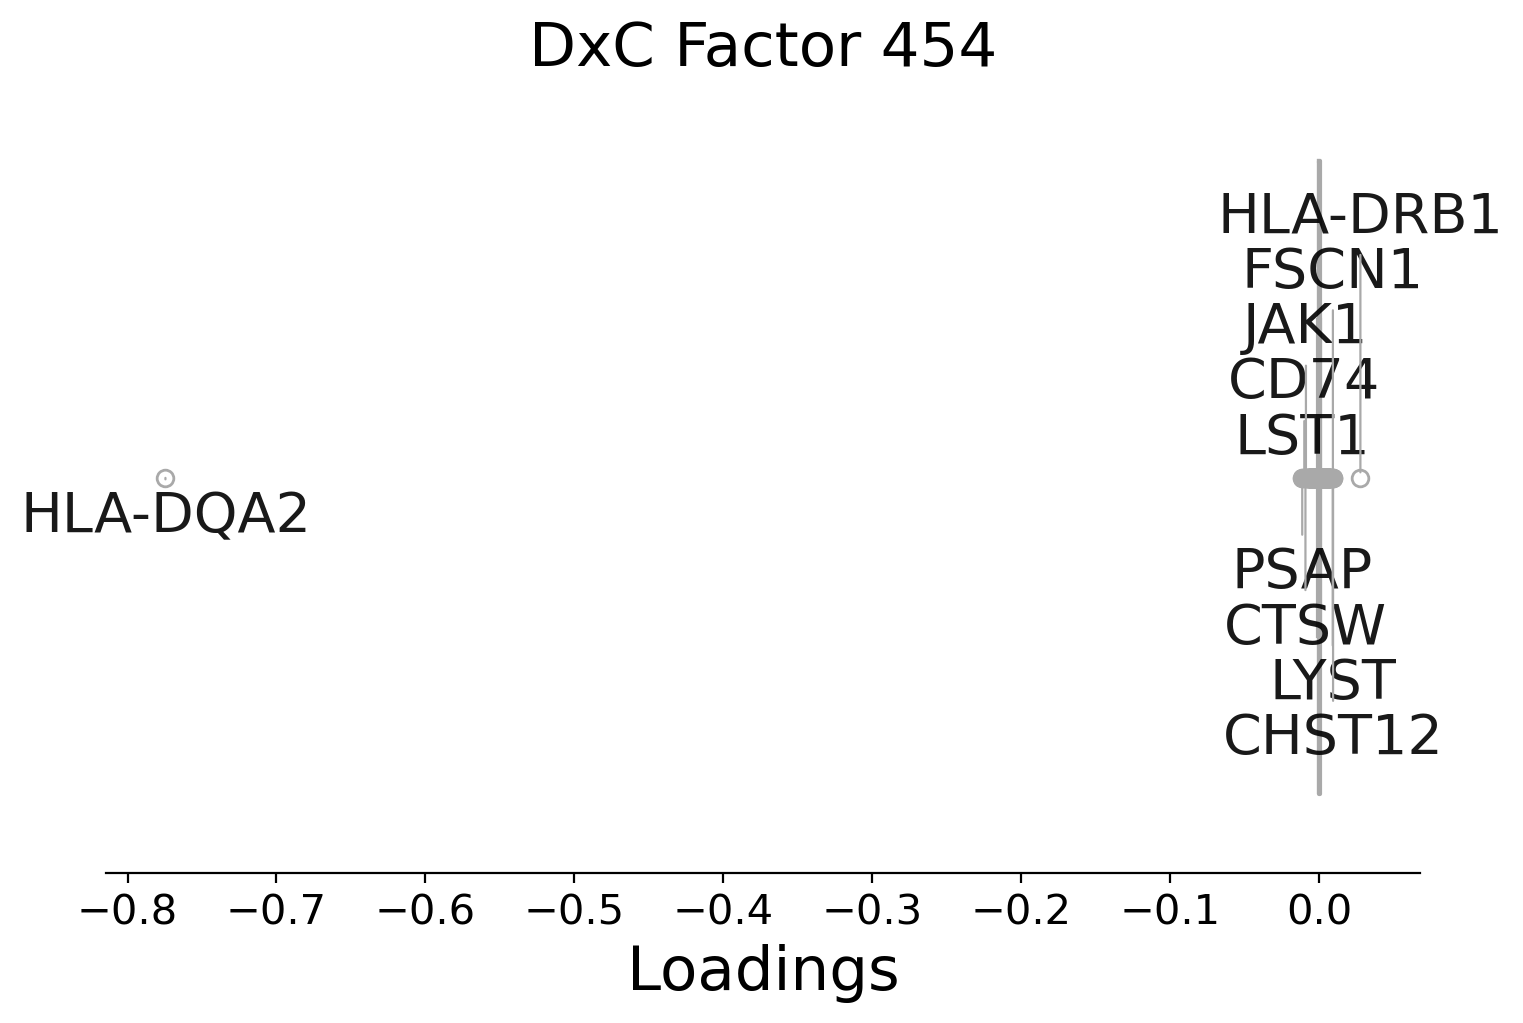

In [147]:
plot_gene_loadings_for_factor(
    DxC_decoder=DxC_decoder,
    factor="DxC_Factor454",
    n_top_genes=10,
    adata_var=adata.var,
    gene_name_column="GeneSymbol",
    color="darkgrey",
    spines_invisible=True,
    annotation_fontsize=20,
    offset = 0.07,
    x_distance=3e-2,
    savefig=os.path.join(model_results_dir, "Figures", "Boxplots_gene-loadings_DxC454.png"),
)

/data/danai/scripts/LIVI/src/analysis/plotting.py:2176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/data/danai/scripts/LIVI/src/analysis/plotting.py:2180: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


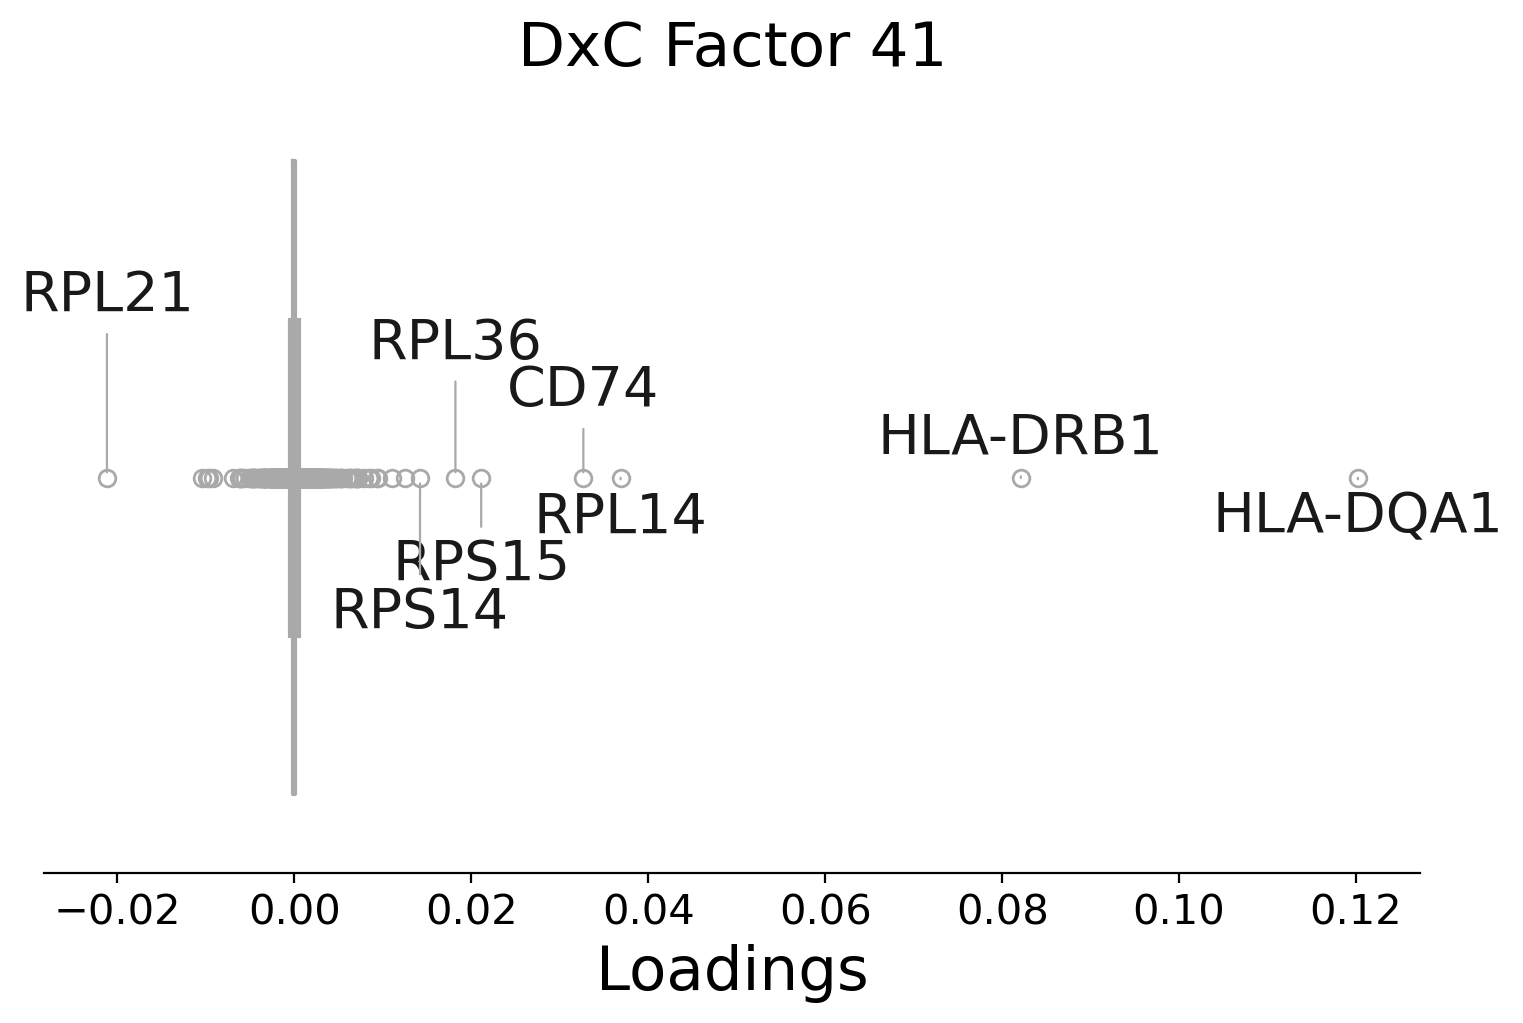

In [151]:
plot_gene_loadings_for_factor(
    DxC_decoder=DxC_decoder,
    factor="DxC_Factor41",
    n_top_genes=8,
    adata_var=adata.var,
    gene_name_column="GeneSymbol",
    color="darkgrey",
    spines_invisible=True,
    annotation_fontsize=20,
    offset = 0.06,
    x_distance=3e-2,
    savefig=os.path.join(model_results_dir, "Figures", "Boxplots_gene-loadings_DxC41.eps"),
)